## **Data Understanding & Preparation**

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import entropy
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

img = 'plots/figure_{}.png'
dataFolder = '../../data/{}'
featureFF = dataFolder.format('feature/')
featureFolder = featureFF+('{}')


## **1 - Data Understanding**

## **1.1 - Data semantics**

Loading the dataset

In [2]:
df = pd.read_csv(dataFolder.format('customer_supermarket.csv'), sep='\t', index_col=0)

In [3]:
df

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,"2,55",17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,"2,75",17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541905,581587,09/12/11 12:50,"2,1",12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,09/12/11 12:50,"4,15",12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,09/12/11 12:50,"4,15",12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4
541908,581587,09/12/11 12:50,"4,95",12680.0,France,22138,BAKING SET 9 PIECE RETROSPOT,3


In [4]:
df.dtypes

BasketID            object
BasketDate          object
Sale                object
CustomerID         float64
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

We obvserve that there are multiple fields signed as object. We can manipulate some of them in order to specify the proper type. According to the head, we have the field Sale that could be converted to a float by simply converting the comma to a dot and then interpret it as a float. Also the BasketDate can be interpret as a datetime64 type.

In [5]:
df['Sale'] = df['Sale'].str.replace(",",".").astype(float) # replace ',' with '.' to make Sale type as float64
df['CustomerID'] = df['CustomerID'].astype('Int64')
df['BasketDate'] = pd.to_datetime(df['BasketDate'])
df = df[df['CustomerID'].notna()]

Let's check the changes we've made. We should see that the Sale field is a float64 and that BasketDate is a datetime64

In [6]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                  Int64
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

Are null values present in the dataset?

In [7]:
df.isnull().any() # customers ids has null values

BasketID           False
BasketDate         False
Sale               False
CustomerID         False
CustomerCountry    False
ProdID             False
ProdDescr          False
Qta                False
dtype: bool

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406830 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         406830 non-null  object        
 1   BasketDate       406830 non-null  datetime64[ns]
 2   Sale             406830 non-null  float64       
 3   CustomerID       406830 non-null  Int64         
 4   CustomerCountry  406830 non-null  object        
 5   ProdID           406830 non-null  object        
 6   ProdDescr        406830 non-null  object        
 7   Qta              406830 non-null  int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 28.3+ MB


## **1.2 - Distributions of the variables & statistics**

## Numerical analysis of the dataset

Let's print some info related to numerical fields present in the dataset. Even if the CustomerID is a numeric field, it should not be interpreted as a number but much more as a label, in this step.

In [9]:
df.describe()[['Sale', 'Qta']]

,Sale,Qta
count,406830.000000,406830.000000
mean,3.460507,12.061276
std,69.315080,248.693065
min,0.000000,-80995.000000
25%,1.250000,2.000000
50%,1.950000,5.000000
75%,3.750000,12.000000
max,38970.000000,80995.000000


## Date distributions

In [10]:
import calendar
import datetime as dt

dates_df = pd.DataFrame({'BasketID': df['BasketID'], 'BasketDate': df['BasketDate']})
#dates_df = dates_df.groupby(['BasketID','BasketDate'], as_index=False).agg(list).reset_index()
dates_df['year'] = dates_df['BasketDate'].dt.year
dates_df['month'] = dates_df['BasketDate'].dt.month
dates_df['month_name'] = dates_df['BasketDate'].dt.month.apply(lambda x: calendar.month_abbr[x])
dates_df['day'] = dates_df['BasketDate'].dt.day
dates_df['day_of_week'] = dates_df['BasketDate'].dt.dayofweek
dates_df['day_of_week_name'] = dates_df['BasketDate'].dt.dayofweek.apply(lambda x: calendar.day_abbr[x])
dates_df[:3]

,BasketID,BasketDate,year,month,month_name,day,day_of_week,day_of_week_name
0,536365,2010-01-12 08:26:00,2010,1,Jan,12,1,Tue
1,536365,2010-01-12 08:26:00,2010,1,Jan,12,1,Tue
2,536365,2010-01-12 08:26:00,2010,1,Jan,12,1,Tue


In [11]:
print('Years: %s' % list(dates_df['year'].unique()))
print('Months: %s' % list(dates_df['month'].unique()))
print('Monts names %s' % list(dates_df['month_name'].unique()))
print('Days: %s' % list(dates_df['day'].unique()))
print('Days of Week: %s' % list(dates_df['day_of_week_name'].unique()))

Years: [2010, 2011]
Months: [1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 4, 11]
Monts names ['Jan', 'Feb', 'Mar', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Dec', 'Apr', 'Nov']
Days: [12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 1, 18, 24, 25, 26, 27, 28, 30, 31, 2, 3, 29, 4, 5, 6, 7, 8, 9, 10, 11]
Days of Week: ['Tue', 'Fri', 'Wed', 'Sat', 'Mon', 'Thu', 'Sun']


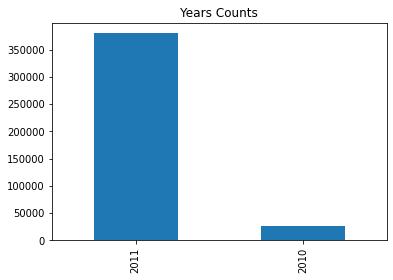

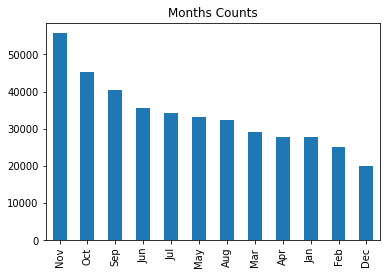

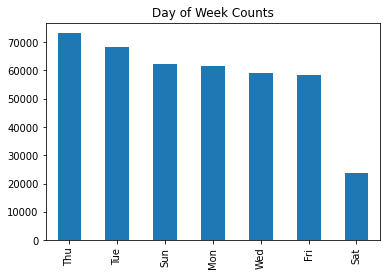

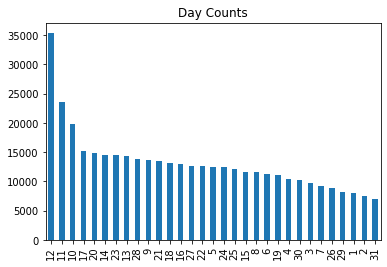

In [12]:
dates_df['year'].value_counts().plot(kind='bar', title='Years Counts')
plt.savefig(img.format('years_count'))
plt.show()

dates_df['month_name'].value_counts().plot(kind='bar', title='Months Counts')
plt.savefig(img.format('months_count'))
plt.show()

dates_df['day_of_week_name'].value_counts().plot(kind='bar', title='Day of Week Counts')
plt.savefig(img.format('day_of_week_count'))
plt.show()

dates_df['day'].value_counts().plot(kind='bar', title='Day Counts')
plt.savefig(img.format('day_count'))
plt.show()

## Customer Country Analysis

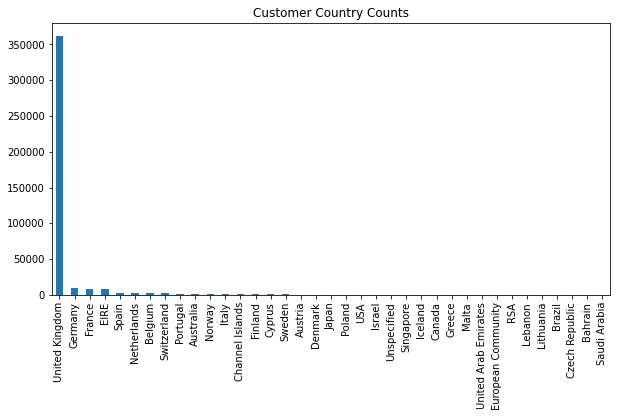

In [13]:
df['CustomerCountry'].value_counts().plot(kind='bar',
                                   title='Customer Country Counts',
                                    figsize=(10,5))
plt.savefig(img.format('customer_country_counts'))
plt.show()

We can observe that the vast majority of the customers are citizens of the United Kingdom, so probabily these records were taken in the UK, while recording also tourists purchases.

## Customer's sale analysis

In [14]:
grouped_df = deepcopy(df[['BasketID', 'Sale', 'Qta','BasketDate', 'CustomerID','CustomerCountry','ProdID']].drop_duplicates())
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401603 entries, 0 to 541909
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         401603 non-null  object        
 1   Sale             401603 non-null  float64       
 2   Qta              401603 non-null  int64         
 3   BasketDate       401603 non-null  datetime64[ns]
 4   CustomerID       401603 non-null  Int64         
 5   CustomerCountry  401603 non-null  object        
 6   ProdID           401603 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 24.9+ MB


In [15]:
grouped_df.info()
grouped_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401603 entries, 0 to 541909
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         401603 non-null  object        
 1   Sale             401603 non-null  float64       
 2   Qta              401603 non-null  int64         
 3   BasketDate       401603 non-null  datetime64[ns]
 4   CustomerID       401603 non-null  Int64         
 5   CustomerCountry  401603 non-null  object        
 6   ProdID           401603 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 24.9+ MB


,Sale,Qta,CustomerID
count,401603.000000,401603.000000,401603.000000
mean,3.474100,12.182551,15281.166099
std,69.764126,250.282937,1714.005038
min,0.000000,-80995.000000,12346.000000
25%,1.250000,2.000000,13939.000000
50%,1.950000,5.000000,15145.000000
75%,3.750000,12.000000,16784.000000
max,38970.000000,80995.000000,18287.000000


In [16]:
pd.DataFrame({'BasketID': [len(grouped_df.BasketID.unique())],
              'CustomerID': [len(grouped_df.CustomerID.unique())],
              'CustomerCountry': [len(grouped_df.CustomerCountry.unique())],
              'ProdID': [len(grouped_df.ProdID.unique())]
})

,BasketID,CustomerID,CustomerCountry,ProdID
0,22190,4372,37,3684


In [17]:
customer_sale_df = deepcopy(grouped_df[['CustomerID','Sale']])
customer_sale_df = customer_sale_df.groupby(['CustomerID'], as_index=False).sum()
customer_sale_df.describe()

,CustomerID,Sale
count,4372.000000,4372.000000
mean,15299.677722,319.123768
std,1722.390705,1281.010193
min,12346.000000,0.000000
25%,13812.750000,52.730000
50%,15300.500000,128.925000
75%,16778.250000,299.097500
max,18287.000000,41376.330000


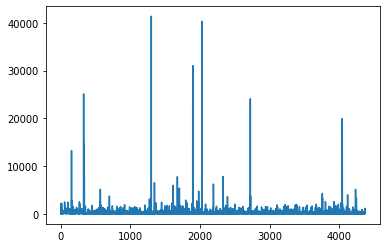

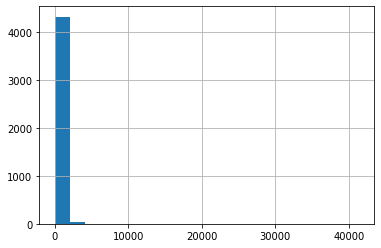

In [18]:
customer_sale_df['Sale'].plot()
plt.savefig(img.format('sale_bar'))
plt.show()

customer_sale_df['Sale'].hist(bins=20)
plt.savefig(img.format('sale_hist'))
plt.show()

In [19]:
print('Number of Sales >= 10000 is %d' % len(customer_sale_df.query('Sale >= 10000')))

Number of Sales >= 10000 is 8


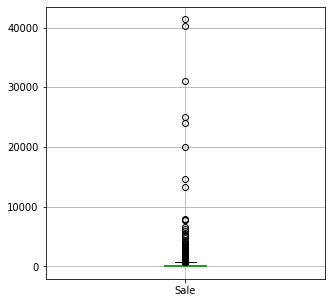

In [20]:
customer_sale_df.boxplot(column=['Sale'], figsize=(5,5))
plt.savefig(img.format('sale_boxplot'))

## Products analysis

We can visually see some possible outliers.

Let's now understand how much cash flow the single products move wrt to sale price and amount of units sold.

In [21]:
prod_df = deepcopy(grouped_df[['ProdID','Sale','Qta']])
prod_df['Amount'] = prod_df['Sale'] * prod_df['Qta']
prod_df.groupby(['ProdID'], as_index=False).sum()
prod_df = prod_df.groupby(['ProdID']).sum()
prod_df = prod_df.drop(columns=['Sale','Qta'])
prod_df[:3]

,Amount
ProdID,
10002,699.55
10080,114.41
10120,40.32


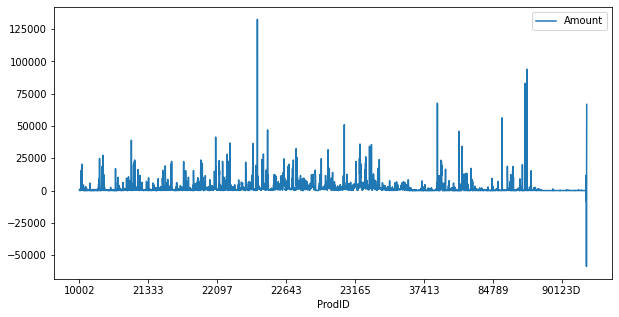

In [22]:
prod_df.plot(figsize=(10,5))
plt.savefig(img.format('ProdID_bar'))

In [23]:
prod_df.describe()

,Amount
count,3684.000000
mean,2247.010199
std,5624.243159
min,-58745.460000
25%,120.582500
50%,608.785000
75%,1995.892500
max,132567.700000


In [24]:
prod_qta_df = deepcopy(grouped_df[['ProdID','Qta']])
prod_qta_df = prod_qta_df.groupby(['ProdID'], as_index=False)['Qta'].sum()
prod_qta_df

,ProdID,Qta
0,10002,823
1,10080,291
2,10120,192
3,10123C,5
4,10124A,16
...,...,...
3679,D,-1194
3680,DOT,16
3681,M,2944
3682,PADS,4


In [25]:
prod_qta_df.describe()

,Qta
count,3684.000000
mean,1328.053474
std,2936.956090
min,-1475.000000
25%,60.000000
50%,375.500000
75%,1367.500000
max,53119.000000


The average quantity of sold items is 1331.94 for the entire period, despite the median is 377.

In [26]:
prod_sale_df = deepcopy(grouped_df[['ProdID','Sale']])
prod_sale_df = prod_sale_df.groupby(['ProdID'], as_index=False)['Sale'].mean()
prod_sale_df[:3]

,ProdID,Sale
0,10002,0.850000
1,10080,0.411905
2,10120,0.210000


In [27]:
prod_sale_df.describe()

,Sale
count,3684.000000
mean,3.841429
std,17.186785
min,0.000750
25%,0.985866
50%,1.950000
75%,3.814202
max,744.147500


We can see that the mean expense for product is 3.91 and that the median is 1.95. The first quartile of the products costs is 1.00 and the last quartile starts from 3.93. Also min and max values have disproportionate total selling values (probably outliers).

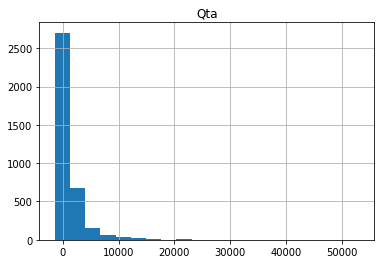

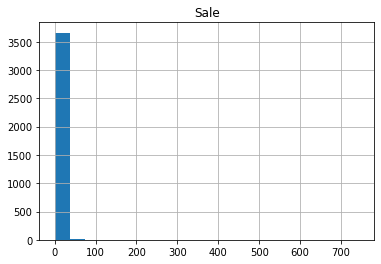

In [28]:
prod_qta_df.hist(bins=20)
plt.savefig(img.format('Qta_hist'))
prod_sale_df.hist(bins=20)
plt.savefig(img.format('sale_hist_2'))

We can see that the data are mostly distributed around 0. Here we used 20 bins according to Sturges' rule.

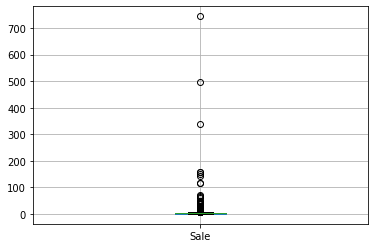

In [29]:
prod_sale_df.boxplot(column=['Sale'])
plt.savefig(img.format('sale_boxplot_2'))

With the boxplot we can easily see how strange it is that very few products are so far from all the others. These are probably outliers.

## **1.3 - Assessing Data Quality**

## Unique values

In [30]:
print("Distinct Values in BasketID: \t", df.BasketID.unique())
print("Distinct Values in CustomerID: \t", df.CustomerID.unique())
print("Distinct Values in CustomerCountry: \t", df.CustomerCountry.unique())
print("Distinct Values in ProdID: \t", df.ProdID.unique())

Distinct Values in BasketID: 	 ['536365' '536366' '536368' ... '581585' '581586' '581587']
Distinct Values in CustomerID: 	 <IntegerArray>
[17850, 13047, 12583, 13748, 15100, 15291, 14688, 17809, 15311, 14527,
 ...
 16000, 15195, 14087, 14204, 15471, 13436, 15520, 13298, 14569, 12713]
Length: 4372, dtype: Int64
Distinct Values in CustomerCountry: 	 ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']
Distinct Values in ProdID: 	 ['85123A' '71053' '84406B' ... '90214Z' '90089' '23843']


## How many unique values in the dataset?

In [31]:
pd.DataFrame({'BasketID': [len(df.BasketID.unique())],
              'CustomerID': [len(df.CustomerID.unique())],
              'CustomerCountry': [len(df.CustomerCountry.unique())],
              'ProdID': [len(df.ProdID.unique())]
})

,BasketID,CustomerID,CustomerCountry,ProdID
0,22190,4372,37,3684


So basically we have:

4373 unique customers coming from a number of countries greater than 38 (because there's also the special value 'Unspecified')
24627 baskets, 4373 customers and 3953 products.

## Negative quantities analysis

## What can we say about the BasketID?
From a first view it may seem that all the BasketID starts with a letter 'C', let's check this hypothesis

In [32]:
negative_df = deepcopy(df.query("Qta < 0"))
negative_df[:3]
first_letters = deepcopy(negative_df['BasketID'].str[0])
print(first_letters.unique())

['C']


We've discovered that all the rows having negative quantities, have BasketIDs that starts with 'C' and with '5'.

In [33]:
negative_df_C = negative_df[negative_df['BasketID'].str[0] == 'C']
negative_df_C[:3]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-01-12 09:41:00,27.50,14527,United Kingdom,D,Discount,-1
154,C536383,2010-01-12 09:49:00,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-01-12 10:24:00,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12


In [34]:
negative_df_C.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8905 entries, 141 to 541717
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BasketID         8905 non-null   object        
 1   BasketDate       8905 non-null   datetime64[ns]
 2   Sale             8905 non-null   float64       
 3   CustomerID       8905 non-null   Int64         
 4   CustomerCountry  8905 non-null   object        
 5   ProdID           8905 non-null   object        
 6   ProdDescr        8905 non-null   object        
 7   Qta              8905 non-null   int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 634.8+ KB


In [35]:
negative_df_C.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID         False
CustomerCountry    False
ProdID             False
ProdDescr          False
Qta                False
dtype: bool

In [36]:
len(negative_df_C['BasketID'].unique())

3654

In [37]:
negative_df_5 = negative_df[negative_df['BasketID'].str[0] == '5']
negative_df_5[:3]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta


In [38]:
negative_df_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BasketID         0 non-null      object        
 1   BasketDate       0 non-null      datetime64[ns]
 2   Sale             0 non-null      float64       
 3   CustomerID       0 non-null      Int64         
 4   CustomerCountry  0 non-null      object        
 5   ProdID           0 non-null      object        
 6   ProdDescr        0 non-null      object        
 7   Qta              0 non-null      int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 0.0+ bytes


In [39]:
negative_df_5.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID         False
CustomerCountry    False
ProdID             False
ProdDescr          False
Qta                False
dtype: bool

In [40]:
len(negative_df_5['BasketID'].unique())

0

According to the previous analysis we can state that all the BasketIDs starting with '5' have no CustomerID specified,
while for the BasketIDs starting with 'C' we have only 821/9084 unspecified CustomerIDs. For each BasketID we can have
multiple rows, so in order to get the right amount of CustomerIDs missing, we have to
drop all the duplicates for each BasketID

In [41]:
negative_df_C_BasketID_CustomerID = negative_df_C[['BasketID', 'CustomerID']]
negative_df_C_BasketID_CustomerID.drop_duplicates(inplace=True)
print(f"{negative_df_C_BasketID_CustomerID.isna().sum().values[1]} / {len(negative_df_C_BasketID_CustomerID)}")

0 / 3654


Finally, we get the proper amount of CustomerIDs missing: 100 / 3754.

## What if we remove the 'C'? Does exist any corrispondence in the main dataframe?

In [42]:
negative_df_BasketID = negative_df['BasketID'].unique()

for el in negative_df_BasketID:
    if el.startswith('C'):
        el = el[1:]
        
positive_df = deepcopy(df.query("Qta > 0"))
positive_df_BasketID = positive_df['BasketID'].unique()

intersection = set(negative_df_BasketID).intersection(set(positive_df_BasketID))
print(len(intersection))

0


According to the previous analysis there's any corrispondence between the BasketIDs having positive quantities and
BasketIDs having negative quantities. So we can say that those are disjoint sets.

## What are the main products having negative quantities?

In [43]:
negative_ProdID_Qta = negative_df[['ProdID', 'Qta']]
negative_ProdID_Qta.describe()


,Qta
count,8905.000000
mean,-30.859966
std,1170.154939
min,-80995.000000
25%,-6.000000
50%,-2.000000
75%,-1.000000
max,-1.000000


In [44]:
negative_ProdID_Qta['Qta'] = negative_ProdID_Qta['Qta'] * -1
negative_ProdID_Qta_sum = negative_ProdID_Qta.groupby('ProdID').sum()
#negative_ProdID_Qta_sum['Qta'] = negative_ProdID_Qta_sum['Qta'] * -1

In [45]:
negative_ProdID_Qta_sum = negative_ProdID_Qta_sum.sort_values('Qta')
negative_ProdID_Qta_sum

,Qta
ProdID,
23466,1
22869,1
22877,1
84968D,1
22878,1
...,...
21108,3150
M,3995
84347,9367


In [46]:
prod_descr = deepcopy(df[['ProdID', 'ProdDescr']].drop_duplicates())
negative_ProdID_Qta_sum = pd.merge(negative_ProdID_Qta_sum, prod_descr, on='ProdID')
negative_ProdID_Qta_sum[-5:]

,ProdID,Qta,ProdDescr
2081,21108,3150,FAIRY CAKE FLANNEL ASSORTED COLOUR
2082,M,3995,Manual
2083,84347,9367,ROTATING SILVER ANGELS T-LIGHT HLDR
2084,23166,74494,MEDIUM CERAMIC TOP STORAGE JAR
2085,23843,80995,"PAPER CRAFT , LITTLE BIRDIE"


We can see that the description for the same ProdID may vary, e.g: product 47566B has 2 different descriptions that 
contains the reasons of that "negative transaction":
- reverse previous adjustment
- incorrectly credited C550456 see 47

Let's drop some product description keeping only one

In [47]:
negative_ProdID_Qta_sum = negative_ProdID_Qta_sum.drop_duplicates(subset = ['ProdID'])
negative_ProdID_Qta_sum[:3]

,ProdID,Qta,ProdDescr
0,23466,1,TUSCAN VILLA DOVECOTE
2,22869,1,NUMBER TILE COTTAGE GARDEN 1
3,22877,1,NUMBER TILE COTTAGE GARDEN 9


Finally we've got the main products having negative quantities with a single description

Median: 13.0


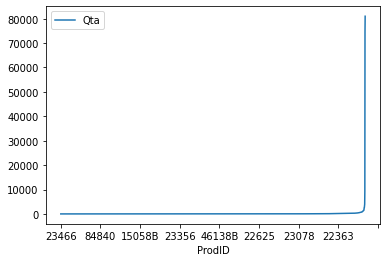

In [48]:
negative_ProdID_Qta_sum.plot(x='ProdID',y= 'Qta')
negative_ProdID_Qta_sum.describe()
print(f"Median: {np.median(negative_ProdID_Qta_sum['Qta'].values)}")
plt.savefig(img.format('negative_ProdID_qta'))

In [49]:
negative_ProdID_Qta_sum.describe()

,Qta
count,1920.000000
mean,143.129167
std,2525.308780
min,1.000000
25%,4.000000
50%,13.000000
75%,38.000000
max,80995.000000


As we can see from the plot, and from the computed statistics, the majority of the quantities both according to
50% percentile (the median) and the 75% percentile are below 16 and 52, but we have also negative quantities up to 80995



## Outliers removal

Removal of outliers, taking into account just the records that falls into the 25% and 75% of the values.

In [50]:
grouped_df = grouped_df[grouped_df.Sale <= grouped_df['Sale'].describe()[6]]
grouped_df = grouped_df[grouped_df.Sale >= grouped_df['Sale'].describe()[4]]

grouped_df = grouped_df[grouped_df.Qta <= grouped_df['Qta'].describe()[6]]
grouped_df = grouped_df[grouped_df.Qta >= grouped_df['Qta'].describe()[4]]

grouped_df.describe()

,Sale,Qta,CustomerID
count,170444.000000,170444.000000,170444.000000
mean,1.958523,7.004259,15257.108575
std,0.819115,3.828382,1711.192182
min,0.850000,2.000000,12347.000000
25%,1.250000,3.000000,13869.000000
50%,1.650000,6.000000,15146.000000
75%,2.550000,12.000000,16764.000000
max,3.750000,12.000000,18287.000000


In [51]:
grouped_df.head()

,BasketID,Sale,Qta,BasketDate,CustomerID,CustomerCountry,ProdID
0,536365,2.55,6,2010-01-12 08:26:00,17850,United Kingdom,85123A
1,536365,3.39,6,2010-01-12 08:26:00,17850,United Kingdom,71053
2,536365,2.75,8,2010-01-12 08:26:00,17850,United Kingdom,84406B
3,536365,3.39,6,2010-01-12 08:26:00,17850,United Kingdom,84029G
4,536365,3.39,6,2010-01-12 08:26:00,17850,United Kingdom,84029E


#### Data Cleaning for GSP

In [52]:
cleaned_df = deepcopy(df[['BasketID', 'Sale', 'Qta','BasketDate', 'CustomerID','CustomerCountry','ProdID','ProdDescr']].drop_duplicates())

cleaned_df = cleaned_df[cleaned_df.Sale <= grouped_df['Sale'].describe()[6]]
cleaned_df = cleaned_df[cleaned_df.Sale >= grouped_df['Sale'].describe()[4]]
cleaned_df = cleaned_df[cleaned_df.Qta <= grouped_df['Qta'].describe()[6]]
cleaned_df = cleaned_df[cleaned_df.Qta >= grouped_df['Qta'].describe()[4]]

cleaned_df.to_csv(dataFolder.format('customer_supermarket_cleaned.csv'))

## **2 - Data Preparation**

We can say that when the total number of products purchased is minor than the distinct number of products purchased is likely that a refund happens.

1. **Min Days Purchase** is the minimum interval of days between two purchases.
2. **Max Days Purchase** is the maximum interval of days between two purchases.
3. **Mean Days Purchase** is the median interval of days between two purchases.

In [53]:
customers = deepcopy(grouped_df[['CustomerID']].dropna().drop_duplicates())
customers

,CustomerID
0,17850
14,13047
28,12583
86,14688
108,15311
...,...
536876,14520
536969,13436
537255,15520
538817,14569


In [54]:
grouped_df.describe()

,Sale,Qta,CustomerID
count,170444.000000,170444.000000,170444.000000
mean,1.958523,7.004259,15257.108575
std,0.819115,3.828382,1711.192182
min,0.850000,2.000000,12347.000000
25%,1.250000,3.000000,13869.000000
50%,1.650000,6.000000,15146.000000
75%,2.550000,12.000000,16764.000000
max,3.750000,12.000000,18287.000000


### Products in Basket
1. **Max Products In Basket** (*lmax*): the maximum number of items purchased by a customer during a shopping session.
2. **Min Products In Basket**
3. **Mean Products In Basket**

In [55]:
# Mean number of distinct products for each basket of the same user
total_number_of_product_in_baskets = grouped_df[['CustomerID', 'BasketID', 'ProdID']].groupby('CustomerID').count()
total_number_of_product_in_baskets['Total Products In Basket'] = total_number_of_product_in_baskets['ProdID']

max_products_in_basket = total_number_of_product_in_baskets.groupby(['CustomerID']).max()
min_products_in_basket = total_number_of_product_in_baskets.groupby(['CustomerID']).min()
mean_products_in_basket = total_number_of_product_in_baskets.groupby(['CustomerID']).mean()

total_number_of_product_in_baskets_with_customerid = customers

mmax = grouped_df[['CustomerID', 'BasketID', 'ProdID']].groupby(['CustomerID', 'BasketID']).count().groupby(['CustomerID']).max()
total_number_of_product_in_baskets['Max Products In Basket'] = mmax['ProdID']  # lmax

mmin = grouped_df[['CustomerID', 'BasketID', 'ProdID']].groupby(['CustomerID', 'BasketID']).count().groupby(['CustomerID']).min()
total_number_of_product_in_baskets['Min Products In Basket'] = mmin['ProdID']

mean = grouped_df[['CustomerID', 'BasketID', 'ProdID']].groupby(['CustomerID', 'BasketID']).count().groupby(['CustomerID']).mean()
total_number_of_product_in_baskets['Mean Products In Basket'] = mean['ProdID']

del total_number_of_product_in_baskets['BasketID']
del total_number_of_product_in_baskets['ProdID']
del total_number_of_product_in_baskets['Total Products In Basket']
total_number_of_product_in_baskets.to_csv(featureFolder.format('products_in_basket.csv'))
total_number_of_product_in_baskets

,Max Products In Basket,Min Products In Basket,Mean Products In Basket
CustomerID,,,
12347,26,4,14.142857
12349,35,35,35.000000
12350,15,15,15.000000
12352,8,1,5.428571
12353,2,2,2.000000
...,...,...,...
18280,6,6,6.000000
18281,2,2,2.000000
18282,2,2,2.000000


### Total products bought (*l*)

In [56]:
total_product_df = grouped_df[['CustomerID','Qta']]
total_product_df['CustomerID'] = total_product_df['CustomerID'].astype(int)
total_product_df = total_product_df.groupby(['CustomerID'], as_index=True).sum()
total_product_df.columns = ['Total Products']

total_product_df.to_csv(featureFolder.format('total_product_bought.csv'))
total_product_df

,Total Products
CustomerID,
12347,916
12349,328
12350,172
12352,365
12353,14
...,...
18280,34
18281,16
18282,25


### Distinct products (*lu*)

In [57]:
distinct_prod_df = grouped_df[['CustomerID','ProdID']]
distinct_prod_df = distinct_prod_df.drop_duplicates()
distinct_prod_df = distinct_prod_df.groupby(['CustomerID']).count()
distinct_prod_df.columns = ['Distinct Products']
distinct_prod_df.to_csv(featureFolder.format('distinct_product_bought.csv'))
distinct_prod_df

,Distinct Products
CustomerID,
12347,66
12349,35
12350,15
12352,31
12353,2
...,...
18280,6
18281,2
18282,4


### Distinct number of baskets for user
Distinct baskets tells us the number of total purchasing sessions a Customer has done.

In [58]:
baskets_analysis = grouped_df[['CustomerID', 'BasketID']].drop_duplicates()
distinct_baskets = baskets_analysis.groupby(['CustomerID']).count()

distinct_baskets['Distinct Baskets'] = distinct_baskets['BasketID']
del distinct_baskets['BasketID']
distinct_baskets.to_csv(featureFolder.format('distinct_basket.csv'))

distinct_baskets

,Distinct Baskets
CustomerID,
12347,7
12349,1
12350,1
12352,7
12353,1
...,...
18280,1
18281,1
18282,2


### Day interval between purchases

In [59]:
from statistics import mean

# number of days in the observation period
max_days_observed_df = deepcopy(df[['BasketDate']].drop_duplicates())
max_days_observed_df = max_days_observed_df.sort_values(by='BasketDate')

# Subtract the first date and the last date
delta = list(max_days_observed_df['BasketDate'])[-1] - list(max_days_observed_df['BasketDate'])[0]

max_days_observed = delta.days
print(f"max_days_observed: {max_days_observed}")

#############

diff_df = grouped_df[['CustomerID','BasketDate']]
diff_df['BasketDate'] = diff_df['BasketDate'].dt.date
diff_df = diff_df.drop_duplicates()

diff_df = diff_df.set_index('CustomerID')
diff_df['previous_visit'] = diff_df.groupby(['CustomerID'])['BasketDate'].shift()

diff_df['diffs'] = diff_df['BasketDate'] - diff_df['previous_visit']
diff_df['diffs'] = diff_df['diffs'].apply(lambda x: abs(x.days))
diff_df['diff'] = diff_df['diffs'].fillna(0)

del diff_df['previous_visit']
del diff_df['diffs']
del diff_df['BasketDate']

diff_df = diff_df.groupby(['CustomerID'])['diff'].agg(list).to_frame()

diff_df['Mean'] = 0
diff_df['Min'] = 0
diff_df['Max'] = 0
diff_df['Mean'] = diff_df['Mean'].astype('float32')
diff_df['Min'] = diff_df['Min'].astype('Int64')
diff_df['Max'] = diff_df['Max'].astype('Int64')

for index, row in diff_df.iterrows():
    row = row.copy()
    v = row['diff']
    if (len(v) > 1) and(.0 in v):
        v.remove(.0)
    mi = min(v)
    ma = max(v)
    mn = mean(v)

    if mi is None or mi == 0:
        mi = max_days_observed
    if ma is None or ma == 0:
        ma = max_days_observed
    if mn is None or mn == 0:
        mn = max_days_observed

    diff_df.at[index, 'diff'] = v
    diff_df.at[index, 'Min'] = mi
    diff_df.at[index, 'Max'] = ma
    diff_df.at[index, 'Mean'] = mn

del diff_df['diff']
diff_df.columns = ['Mean Days btw Purchases','Min Days btw Purchases','Max Days btw Purchases']
diff_df.to_csv(featureFolder.format('difference_days_purchases.csv'))
diff_df

max_days_observed: 697


,Mean Days btw Purchases,Min Days btw Purchases,Max Days btw Purchases
CustomerID,,,
12347,167.833328,64,265
12349,697.000000,697,697
12350,697.000000,697,697
12352,85.500000,5,201
12353,697.000000,697,697
...,...,...,...
18280,697.000000,697,697
18281,697.000000,697,697
18282,85.000000,85,85


## Sales of the 1st and 2nd semesters per customers

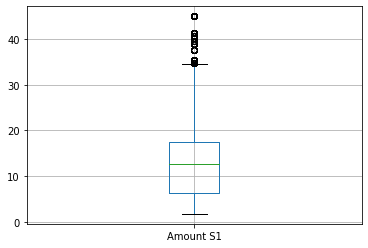

In [60]:
sales_semester_1_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month <= 6])
sales_semester_1_df = sales_semester_1_df[['CustomerID','Sale','Qta']]
sales_semester_1_df['Amount'] = sales_semester_1_df['Sale'] * sales_semester_1_df['Qta']
sales_semester_1_df = sales_semester_1_df.drop(columns=['Sale'])
sales_semester_1_df.columns = ['CustomerID','Qta S1','Amount S1']
sales_semester_1_df.boxplot(column=['Amount S1'])
plt.savefig(img.format('amount_s1_boxplot'))

In [61]:
sales_semester_1_df['Amount S1'].describe()

count    76072.000000
mean        12.789632
std          7.588024
min          1.700000
25%          6.240000
50%         12.600000
75%         17.550000
max         45.000000
Name: Amount S1, dtype: float64

In [62]:
sales_semester_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76072 entries, 0 to 532897
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  76072 non-null  Int64  
 1   Qta S1      76072 non-null  int64  
 2   Amount S1   76072 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 2.4 MB


In [63]:
sales_semester_1_df = sales_semester_1_df[sales_semester_1_df['Amount S1'] <= sales_semester_1_df['Amount S1'].describe()[6]]
sales_semester_1_df = sales_semester_1_df[sales_semester_1_df['Amount S1'] >= sales_semester_1_df['Amount S1'].describe()[4]]
sales_semester_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43451 entries, 0 to 532897
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  43451 non-null  Int64  
 1   Qta S1      43451 non-null  int64  
 2   Amount S1   43451 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.4 MB


After the outliers removal in the Semester 1 we have 43451 records (instead of 76072), keeping just the records where customers spent from 6.24 to 17.55.

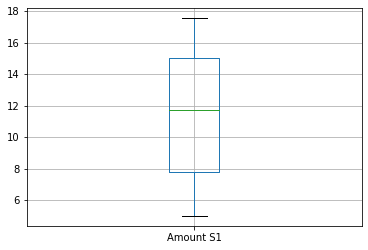

In [64]:
sales_semester_1_df.boxplot(column=['Amount S1'])
plt.savefig(img.format('amount_s1_boxplot_without_outliers'))

In [65]:
sales_semester_1_df = sales_semester_1_df.groupby(['CustomerID'], as_index=False).mean()
sales_semester_1_df.columns = ['CustomerID','Mean Qta S1','Mean Money Spent S1']
sales_semester_1_df

,CustomerID,Mean Qta S1,Mean Money Spent S1
0,12347,7.294118,13.050588
1,12350,11.714286,13.728571
2,12352,10.416667,14.894167
3,12353,8.000000,11.600000
4,12354,8.866667,12.763333
...,...,...,...
2600,18270,10.500000,14.175000
2601,18272,8.933333,14.980000
2602,18282,4.000000,13.000000
2603,18283,4.000000,6.540645


Analyzing the Semester 2

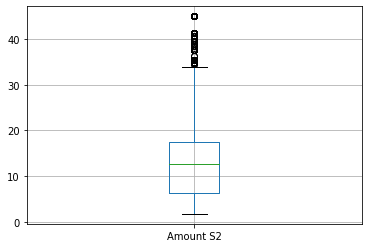

In [66]:
sales_semester_2_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month > 6])
sales_semester_2_df = sales_semester_2_df[['CustomerID','Sale','Qta']]
sales_semester_2_df['Amount'] = sales_semester_2_df['Sale'] * sales_semester_2_df['Qta']
sales_semester_2_df = sales_semester_2_df.drop(columns=['Sale'])
sales_semester_2_df.columns = ['CustomerID','Qta S2','Amount S2']
sales_semester_2_df.boxplot(column=['Amount S2'])
plt.savefig(img.format('amount_s2_boxplot'))

In [67]:
sales_semester_2_df['Amount S2'].describe()

count    94372.000000
mean        12.917693
std          7.691724
min          1.700000
25%          6.250000
50%         12.600000
75%         17.400000
max         45.000000
Name: Amount S2, dtype: float64

In [68]:
sales_semester_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94372 entries, 14025 to 541905
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  94372 non-null  Int64  
 1   Qta S2      94372 non-null  int64  
 2   Amount S2   94372 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 3.0 MB


In [69]:
sales_semester_2_df = sales_semester_2_df[sales_semester_2_df['Amount S2'] <= sales_semester_2_df['Amount S2'].describe()[6]]
sales_semester_2_df = sales_semester_2_df[sales_semester_2_df['Amount S2'] >= sales_semester_2_df['Amount S2'].describe()[4]]
sales_semester_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53858 entries, 14025 to 541905
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  53858 non-null  Int64  
 1   Qta S2      53858 non-null  int64  
 2   Amount S2   53858 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.7 MB


After the outliers removal in the Semester 2 we have 53858 records (instead of 94372), keeping just the records where customers spent from 6.25 to 17.40.

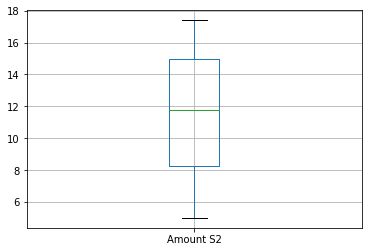

In [70]:
sales_semester_2_df.boxplot(column=['Amount S2'])
plt.savefig(img.format('amount_s2_boxplot_without_outliers'))

In [71]:
sales_semester_2_df = sales_semester_2_df.groupby(['CustomerID'], as_index=False).mean()
sales_semester_2_df.columns = ['CustomerID','Mean Qta S2','Mean Money Spent S2']
sales_semester_2_df

,CustomerID,Mean Qta S2,Mean Money Spent S2
0,12347,9.222222,13.617778
1,12349,8.800000,14.474667
2,12352,8.250000,15.512500
3,12356,7.000000,10.510000
4,12358,8.000000,15.000000
...,...,...,...
2968,18278,9.333333,13.400000
2969,18280,4.666667,15.100000
2970,18281,8.000000,15.900000
2971,18283,3.961538,7.786154


In [72]:
sales_semester_1_df = sales_semester_1_df.set_index('CustomerID')
sales_semester_2_df = sales_semester_2_df.set_index('CustomerID')

sales_semester_df = customers
sales_semester_df = sales_semester_df.join(sales_semester_1_df, on='CustomerID')
sales_semester_df = sales_semester_df.join(sales_semester_2_df, on='CustomerID')
sales_semester_df = sales_semester_df.fillna(0)
sales_semester_df = sales_semester_df.set_index('CustomerID')

In [73]:
# sales_semester_df.to_csv(featureFolder.format('sales_semester.csv'))
sales_semester_df

,Mean Qta S1,Mean Money Spent S1,Mean Qta S2,Mean Money Spent S2
CustomerID,,,,
17850,6.119205,10.480927,0.000000,0.000000
13047,7.750000,14.056875,7.846154,13.416923
12583,8.777778,11.878889,9.538462,12.647692
14688,6.855072,9.941594,7.677419,10.281613
15311,4.529183,8.109883,5.161538,8.609731
...,...,...,...,...
14520,0.000000,0.000000,12.000000,10.200000
13436,0.000000,0.000000,6.400000,13.848000
15520,0.000000,0.000000,12.000000,12.600000


In [74]:
# dropping all zero values to compare customers behavior
sales_semester_nonzero_df = sales_semester_df[sales_semester_df['Mean Money Spent S1'] != 0]
sales_semester_nonzero_df = sales_semester_df[sales_semester_df['Mean Money Spent S2'] != 0]

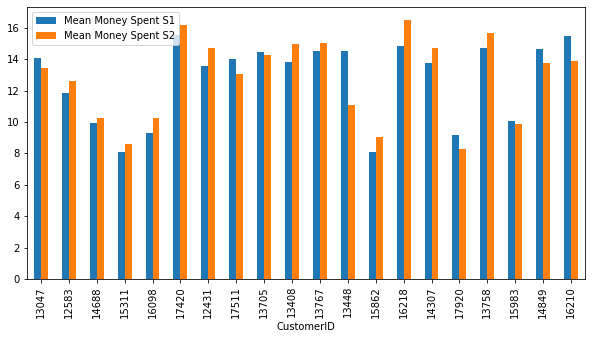

In [75]:
sales_semester_nonzero_df[['Mean Money Spent S1','Mean Money Spent S2']][:20].plot(kind='bar',figsize=(10,5))
plt.savefig(img.format('customers_with_S12_bar'))

Here we can see the comparison between just 20 customers (for the sake of presentation) representing the total expense in the 2 different semesters. We can notice that in some cases customers spent more money on the second semester, other times in the first. Maybe this is a hint to acknowledge that some products are seasonal.

Let's verify it with a correlation matrix.

In [76]:
sales_semester_df.corr(method='pearson')

,Mean Qta S1,Mean Money Spent S1,Mean Qta S2,Mean Money Spent S2
Mean Qta S1,1.00000,0.94193,-0.062320,-0.094260
Mean Money Spent S1,0.94193,1.00000,-0.100080,-0.115880
Mean Qta S2,-0.06232,-0.10008,1.000000,0.926123
Mean Money Spent S2,-0.09426,-0.11588,0.926123,1.000000


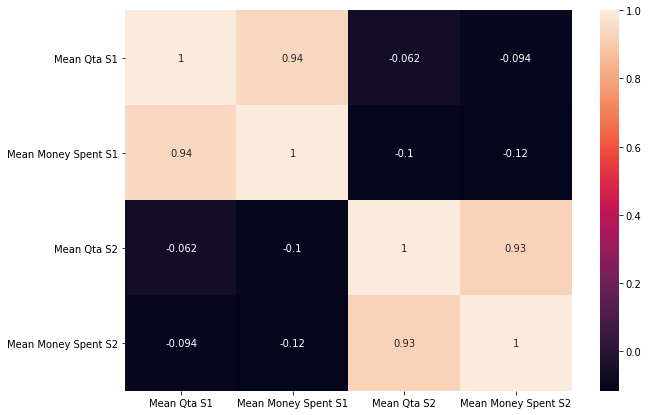

In [77]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(sales_semester_df.corr(method='pearson'), annot=True, ax=ax)
plt.savefig(img.format('S12_heatmap_correlation'))

As we can see the quantities and the amounts registered in the same semester are highly correlated, so more the products bought, more the expense. While in different semesters we notice slightly different habits in purchases by customers, despite having a quite high correlation (~0.68)

## Sales of 1st, 2nd and 3rd quarters per customer

Analyzing the 1st quarter

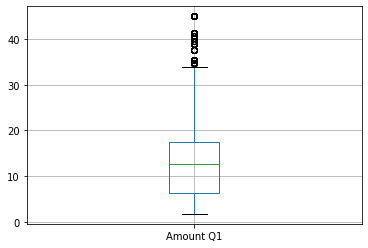

In [78]:
sales_quarter_1_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month <= 4])
sales_quarter_1_df = sales_quarter_1_df[['CustomerID','Sale','Qta']]
sales_quarter_1_df['Amount'] = sales_quarter_1_df['Sale'] * sales_quarter_1_df['Qta']
sales_quarter_1_df = sales_quarter_1_df.drop(columns=['Sale'])
sales_quarter_1_df.columns = ['CustomerID','Qta Q1','Amount Q1']
sales_quarter_1_df.boxplot(column=['Amount Q1'])
plt.savefig(img.format('amount_q1_boxplot'))

In [79]:
sales_quarter_1_df['Amount Q1'].describe()

count    47571.000000
mean        12.822668
std          7.576652
min          1.700000
25%          6.250000
50%         12.600000
75%         17.400000
max         45.000000
Name: Amount Q1, dtype: float64

In [80]:
sales_quarter_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47571 entries, 0 to 524190
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  47571 non-null  Int64  
 1   Qta Q1      47571 non-null  int64  
 2   Amount Q1   47571 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.5 MB


In [81]:
sales_quarter_1_df = sales_quarter_1_df[sales_quarter_1_df['Amount Q1'] <= sales_quarter_1_df['Amount Q1'].describe()[6]]
sales_quarter_1_df = sales_quarter_1_df[sales_quarter_1_df['Amount Q1'] >= sales_quarter_1_df['Amount Q1'].describe()[4]]
sales_quarter_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26814 entries, 0 to 524188
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  26814 non-null  Int64  
 1   Qta Q1      26814 non-null  int64  
 2   Amount Q1   26814 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 864.1 KB


After the outliers removal in the Quarter 1 we have 26814 records (instead of 47571), keeping just the records where customers spent from 6.25 to 17.40.

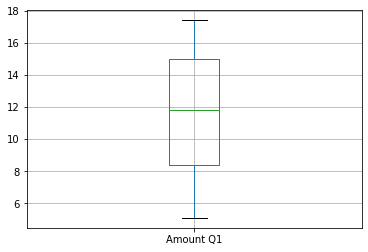

In [82]:
sales_quarter_1_df.boxplot(column=['Amount Q1'])
plt.savefig(img.format('amount_q1_boxplot_without_outliers'))

In [83]:
sales_quarter_1_df = sales_quarter_1_df.groupby(['CustomerID'], as_index=False).mean()
sales_quarter_1_df.columns = ['CustomerID','Mean Qta Q1','Mean Money Spent Q1']
sales_quarter_1_df

,CustomerID,Mean Qta Q1,Mean Money Spent Q1
0,12347,7.294118,13.050588
1,12350,11.714286,13.728571
2,12352,10.416667,14.894167
3,12354,8.866667,12.763333
4,12356,12.000000,17.400000
...,...,...,...
2019,18265,7.000000,14.550000
2020,18270,10.500000,14.175000
2021,18272,8.933333,14.980000
2022,18282,4.000000,13.000000


Analyzing the Q2

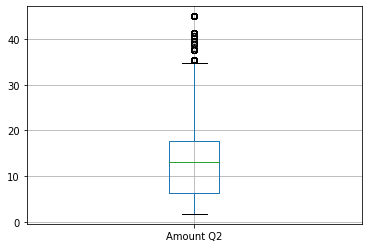

In [84]:
sales_quarter_2_df = deepcopy(grouped_df[((grouped_df['BasketDate'].dt.month > 4) & (grouped_df['BasketDate'].dt.month <= 8))])
sales_quarter_2_df = sales_quarter_2_df[['CustomerID','Sale','Qta']]
sales_quarter_2_df['Amount'] = sales_quarter_2_df['Sale'] * sales_quarter_2_df['Qta']
sales_quarter_2_df = sales_quarter_2_df.drop(columns=['Sale'])
sales_quarter_2_df.columns = ['CustomerID','Qta Q2','Amount Q2']
sales_quarter_2_df.boxplot(column=['Amount Q2'])
plt.savefig(img.format('amount_q2_boxplot'))

In [85]:
sales_quarter_2_df['Amount Q2'].describe()

count    56275.000000
mean        12.940355
std          7.508566
min          1.700000
25%          6.300000
50%         13.160000
75%         17.700000
max         45.000000
Name: Amount Q2, dtype: float64

In [86]:
sales_quarter_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56275 entries, 7422 to 540247
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  56275 non-null  Int64  
 1   Qta Q2      56275 non-null  int64  
 2   Amount Q2   56275 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.8 MB


Remove the outliers for Q2

In [87]:
sales_quarter_2_df = sales_quarter_2_df[sales_quarter_2_df['Amount Q2'] <= sales_quarter_2_df['Amount Q2'].describe()[6]]
sales_quarter_2_df = sales_quarter_2_df[sales_quarter_2_df['Amount Q2'] >= sales_quarter_2_df['Amount Q2'].describe()[4]]
sales_quarter_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34202 entries, 7426 to 540244
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  34202 non-null  Int64  
 1   Qta Q2      34202 non-null  int64  
 2   Amount Q2   34202 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.1 MB


After the outliers removal in the Quarter 2 we have 34202 records (instead of 56275), keeping just the records where customers spent from 6.30 to 17.70.

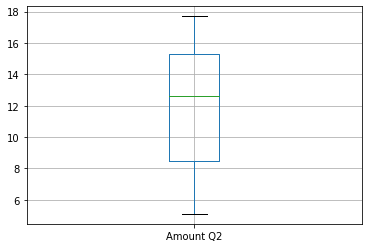

In [88]:
sales_quarter_2_df.boxplot(column=['Amount Q2'])
plt.savefig(img.format('amount_q2_boxplot_without_outliers'))

In [89]:
sales_quarter_2_df = sales_quarter_2_df.groupby(['CustomerID'], as_index=False).mean()
sales_quarter_2_df.columns = ['CustomerID','Mean Qta Q2','Mean Money Spent Q2']
sales_quarter_2_df

,CustomerID,Mean Qta Q2,Mean Money Spent Q2
0,12347,9.000000,14.376154
1,12353,7.000000,14.650000
2,12356,7.000000,10.510000
3,12357,10.363636,15.027273
4,12359,8.117647,14.594118
...,...,...,...
2206,18272,9.657143,15.110857
2207,18280,5.200000,16.140000
2208,18282,6.000000,17.700000
2209,18283,3.909091,7.275455


Analyzing the Q3

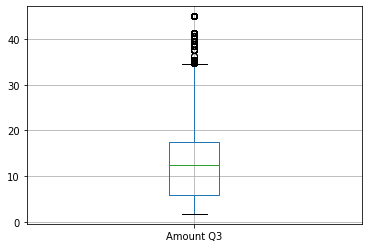

In [90]:
sales_quarter_3_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month > 8])
sales_quarter_3_df = sales_quarter_3_df[['CustomerID','Sale','Qta']]
sales_quarter_3_df['Amount'] = sales_quarter_3_df['Sale'] * sales_quarter_3_df['Qta']
sales_quarter_3_df = sales_quarter_3_df.drop(columns=['Sale'])
sales_quarter_3_df.columns = ['CustomerID','Qta Q3','Amount Q3']
sales_quarter_3_df.boxplot(column=['Amount Q3'])
plt.savefig(img.format('amount_q3_boxplot'))

In [91]:
sales_quarter_3_df['Amount Q3'].describe()

count    66598.000000
mean        12.820142
std          7.807907
min          1.700000
25%          5.950000
50%         12.500000
75%         17.400000
max         45.000000
Name: Amount Q3, dtype: float64

In [92]:
sales_quarter_3_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66598 entries, 19634 to 541905
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  66598 non-null  Int64  
 1   Qta Q3      66598 non-null  int64  
 2   Amount Q3   66598 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 2.1 MB


Remove the outliers for Q3

In [93]:
sales_quarter_3_df = sales_quarter_3_df[sales_quarter_3_df['Amount Q3'] <= sales_quarter_3_df['Amount Q3'].describe()[6]]
sales_quarter_3_df = sales_quarter_3_df[sales_quarter_3_df['Amount Q3'] >= sales_quarter_3_df['Amount Q3'].describe()[4]]
sales_quarter_3_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37806 entries, 19634 to 541905
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  37806 non-null  Int64  
 1   Qta Q3      37806 non-null  int64  
 2   Amount Q3   37806 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.2 MB


After the outliers removal in the Quarter 3 we have 37806 records (instead of 66598), keeping just the records where customers spent from 5.95 to 17.40.

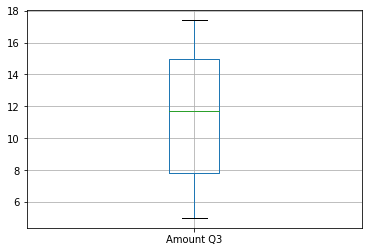

In [94]:
sales_quarter_3_df.boxplot(column=['Amount Q3'])
plt.savefig(img.format('amount_q1_boxplot_without_outliers'))

In [95]:
sales_quarter_3_df = sales_quarter_3_df.groupby(['CustomerID'], as_index=False).mean()
sales_quarter_3_df.columns = ['CustomerID','Mean Qta Q3','Mean Money Spent Q3']

In [96]:
sales_quarter_1_df = sales_quarter_1_df.set_index('CustomerID')
sales_quarter_2_df = sales_quarter_2_df.set_index('CustomerID')
sales_quarter_3_df = sales_quarter_3_df.set_index('CustomerID')


sales_quarter_df = customers
sales_quarter_df = sales_quarter_df.join(sales_quarter_1_df, on='CustomerID')
sales_quarter_df = sales_quarter_df.join(sales_quarter_2_df, on='CustomerID')
sales_quarter_df = sales_quarter_df.join(sales_quarter_3_df, on='CustomerID')
sales_quarter_df = sales_quarter_df.fillna(0)

sales_quarter_df = sales_quarter_df.set_index('CustomerID')

In [97]:
sales_quarter_df.to_csv(featureFolder.format('sales_quarter.csv'))
sales_quarter_df

,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3
CustomerID,,,,,,
17850,6.119205,10.480927,0.000000,0.000000,0.000000,0.000000
13047,8.285714,14.540000,6.571429,14.112857,7.846154,13.416923
12583,12.000000,10.200000,9.128205,12.865128,9.157895,12.133684
14688,7.339623,10.489057,6.913043,9.363043,7.190476,10.401429
15311,4.766304,8.426033,4.536424,8.101788,5.319277,8.848193
...,...,...,...,...,...,...
14520,0.000000,0.000000,12.000000,10.200000,0.000000,0.000000
13436,0.000000,0.000000,6.400000,13.848000,0.000000,0.000000
15520,0.000000,0.000000,12.000000,12.600000,0.000000,0.000000


In [98]:
# dropping all zero values to compare customers behavior
sales_quarter_nonzero_df = sales_quarter_df[sales_quarter_df['Mean Money Spent Q1'] != 0]
sales_quarter_nonzero_df = sales_quarter_df[sales_quarter_df['Mean Money Spent Q2'] != 0]
sales_quarter_nonzero_df = sales_quarter_df[sales_quarter_df['Mean Money Spent Q3'] != 0]

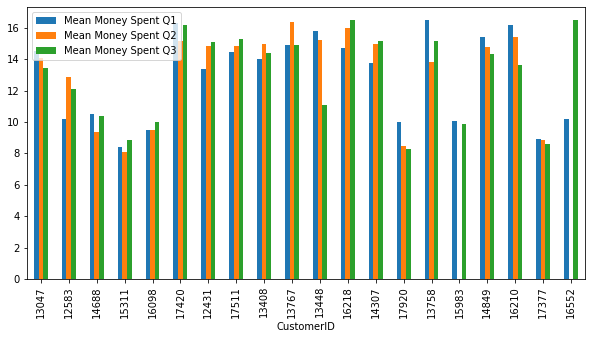

In [99]:
sales_quarter_nonzero_df[['Mean Money Spent Q1','Mean Money Spent Q2','Mean Money Spent Q3']][:20].plot(kind='bar',figsize=(10,5))
plt.savefig(img.format('customers_with_Q123_bar'))

Here we can see the comparison between just 20 customers (for the sake of presentation) representing the total expense in the 3 different quarters. Some of the customers seems to spend mostly in one of the trimesters, others are more constant buyers.

In [100]:
sales_quarter_df.corr(method='pearson')

,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3
Mean Qta Q1,1.000000,0.952125,0.116135,0.097305,0.023455,0.008349
Mean Money Spent Q1,0.952125,1.000000,0.100757,0.095805,0.003830,0.000586
Mean Qta Q2,0.116135,0.100757,1.000000,0.940702,0.075323,0.057690
Mean Money Spent Q2,0.097305,0.095805,0.940702,1.000000,0.051589,0.048904
Mean Qta Q3,0.023455,0.003830,0.075323,0.051589,1.000000,0.940492
Mean Money Spent Q3,0.008349,0.000586,0.057690,0.048904,0.940492,1.000000


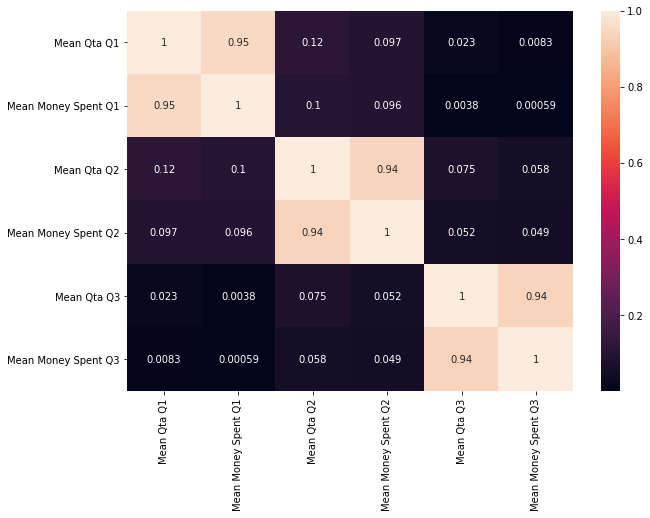

In [101]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(sales_quarter_df.corr(method='pearson'), annot=True, ax=ax)
plt.savefig(img.format('Q123_heatmap_correlation'))

As we can see the quantities and the amounts registered in the same quarter are highly correlated, so more the products bought, more the expense. While in different quarters we notice different habits in purchases by customers.

## Sales of 1st, 2nd, 3rd and 4th trimesters per customer

Analyzing the T1

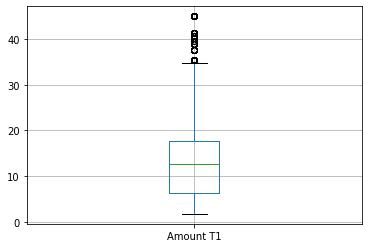

In [102]:
sales_trimester_1_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month <= 3])
sales_trimester_1_df = sales_trimester_1_df[['CustomerID','Sale','Qta']]
sales_trimester_1_df['Amount'] = sales_trimester_1_df['Sale'] * sales_trimester_1_df['Qta']
sales_trimester_1_df = sales_trimester_1_df.drop(columns=['Sale'])
sales_trimester_1_df.columns = ['CustomerID','Qta T1','Amount T1']
sales_trimester_1_df.boxplot(column=['Amount T1'])
plt.savefig(img.format('amount_t1_boxplot'))

In [103]:
sales_trimester_1_df['Amount T1'].describe()

count    35800.000000
mean        12.811976
std          7.588013
min          1.700000
25%          6.250000
50%         12.600000
75%         17.700000
max         45.000000
Name: Amount T1, dtype: float64

In [104]:
sales_trimester_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35800 entries, 0 to 522156
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  35800 non-null  Int64  
 1   Qta T1      35800 non-null  int64  
 2   Amount T1   35800 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.1 MB


In [105]:
sales_trimester_1_df = sales_trimester_1_df[sales_trimester_1_df['Amount T1'] <= sales_trimester_1_df['Amount T1'].describe()[6]]
sales_trimester_1_df = sales_trimester_1_df[sales_trimester_1_df['Amount T1'] >= sales_trimester_1_df['Amount T1'].describe()[4]]
sales_trimester_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22450 entries, 0 to 522137
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  22450 non-null  Int64  
 1   Qta T1      22450 non-null  int64  
 2   Amount T1   22450 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 723.5 KB


After the outliers removal in the Trimester 1 we have 22450 records (instead of 35800), keeping just the records where customers spent from 6.25 to 17.70.

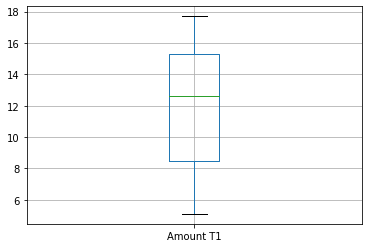

In [106]:
sales_trimester_1_df.boxplot(column=['Amount T1'])
plt.savefig(img.format('amount_t1_boxplot_without_outliers'))

In [107]:
sales_trimester_1_df = sales_trimester_1_df.groupby(['CustomerID'], as_index=False).mean()
sales_trimester_1_df.columns = ['CustomerID','Mean Qta T1','Mean Money Spent T1']
sales_trimester_1_df

,CustomerID,Mean Qta T1,Mean Money Spent T1
0,12347,7.157895,13.540000
1,12350,11.000000,14.225000
2,12352,9.117647,15.719412
3,12356,12.000000,17.400000
4,12359,9.250000,14.387500
...,...,...,...
1724,18260,9.625000,14.543750
1725,18263,12.000000,15.000000
1726,18270,10.500000,14.175000
1727,18282,5.000000,15.350000


Analyzing the T2

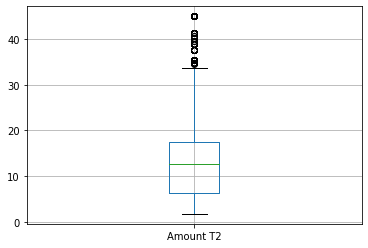

In [108]:
sales_trimester_2_df = deepcopy(grouped_df[((grouped_df['BasketDate'].dt.month > 3) & (grouped_df['BasketDate'].dt.month <= 6))])
sales_trimester_2_df = sales_trimester_2_df[['CustomerID','Sale','Qta']]
sales_trimester_2_df['Amount'] = sales_trimester_2_df['Sale'] * sales_trimester_2_df['Qta']
sales_trimester_2_df = sales_trimester_2_df.drop(columns=['Sale'])
sales_trimester_2_df.columns = ['CustomerID','Qta T2','Amount T2']
sales_trimester_2_df.boxplot(column=['Amount T2'])
plt.savefig(img.format('amount_t2_boxplot'))

In [109]:
sales_trimester_2_df['Amount T2'].describe()

count    40272.000000
mean        12.769769
std          7.588072
min          1.700000
25%          6.240000
50%         12.600000
75%         17.400000
max         45.000000
Name: Amount T2, dtype: float64

In [110]:
sales_trimester_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40272 entries, 7422 to 532897
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  40272 non-null  Int64  
 1   Qta T2      40272 non-null  int64  
 2   Amount T2   40272 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.3 MB


In [111]:
sales_trimester_2_df = sales_trimester_2_df[sales_trimester_2_df['Amount T2'] <= sales_trimester_2_df['Amount T2'].describe()[6]]
sales_trimester_2_df = sales_trimester_2_df[sales_trimester_2_df['Amount T2'] >= sales_trimester_2_df['Amount T2'].describe()[4]]
sales_trimester_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22793 entries, 7426 to 532897
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  22793 non-null  Int64  
 1   Qta T2      22793 non-null  int64  
 2   Amount T2   22793 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 734.5 KB


After the outliers removal in the Trimester 2 we have 22793 records (instead of 40272), keeping just the records where customers spent from 6.24 to 17.40.

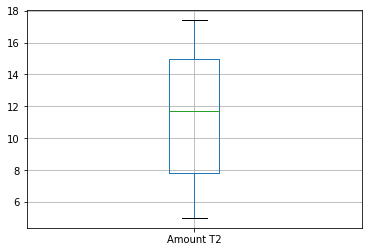

In [112]:
sales_trimester_2_df.boxplot(column=['Amount T2'])
plt.savefig(img.format('amount_t2_boxplot_without_outliers'))

In [113]:
sales_trimester_2_df = sales_trimester_2_df.groupby(['CustomerID'], as_index=False).mean()
sales_trimester_2_df.columns = ['CustomerID','Mean Qta T2','Mean Money Spent T2']
sales_trimester_2_df

,CustomerID,Mean Qta T2,Mean Money Spent T2
0,12353,8.000000,11.600000
1,12354,8.866667,12.763333
2,12357,10.363636,15.027273
3,12360,9.000000,11.558889
4,12362,8.846154,13.750000
...,...,...,...
1794,18261,7.777778,14.200000
1795,18265,7.000000,14.550000
1796,18272,8.933333,14.980000
1797,18283,3.500000,6.448333


Analyzing the T3

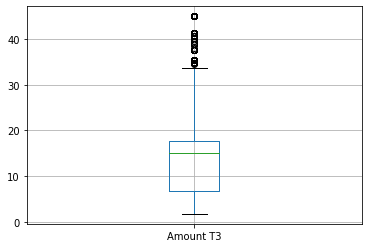

In [114]:
sales_trimester_3_df = deepcopy(grouped_df[((grouped_df['BasketDate'].dt.month > 6) & (grouped_df['BasketDate'].dt.month <= 9))])
sales_trimester_3_df = sales_trimester_3_df[['CustomerID','Sale','Qta']]
sales_trimester_3_df['Amount'] = sales_trimester_3_df['Sale'] * sales_trimester_3_df['Qta']
sales_trimester_3_df = sales_trimester_3_df.drop(columns=['Sale'])
sales_trimester_3_df.columns = ['CustomerID','Qta T3','Amount T3']
sales_trimester_3_df.boxplot(column=['Amount T3'])
plt.savefig(img.format('amount_t3_boxplot'))

In [115]:
sales_trimester_3_df['Amount T3'].describe()

count    45046.000000
mean        13.372665
std          7.528852
min          1.700000
25%          6.800000
50%         15.000000
75%         17.700000
max         45.000000
Name: Amount T3, dtype: float64

In [116]:
sales_trimester_3_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45046 entries, 14025 to 541905
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  45046 non-null  Int64  
 1   Qta T3      45046 non-null  int64  
 2   Amount T3   45046 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.4 MB


In [117]:
sales_trimester_3_df = sales_trimester_3_df[sales_trimester_3_df['Amount T3'] <= sales_trimester_3_df['Amount T3'].describe()[6]]
sales_trimester_3_df = sales_trimester_3_df[sales_trimester_3_df['Amount T3'] >= sales_trimester_3_df['Amount T3'].describe()[4]]
sales_trimester_3_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26624 entries, 14025 to 541905
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  26624 non-null  Int64  
 1   Qta T3      26624 non-null  int64  
 2   Amount T3   26624 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 858.0 KB


After the outliers removal in the Trimester 3 we have 26624 records (instead of 45046), keeping just the records where customers spent from 6.80 to 17.70.

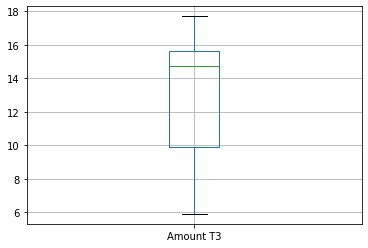

In [118]:
sales_trimester_3_df.boxplot(column=['Amount T3'])
plt.savefig(img.format('amount_t3_boxplot_without_outliers'))

In [119]:
sales_trimester_3_df = sales_trimester_3_df.groupby(['CustomerID'], as_index=False).mean()
sales_trimester_3_df.columns = ['CustomerID','Mean Qta T3','Mean Money Spent T3']
sales_trimester_3_df

,CustomerID,Mean Qta T3,Mean Money Spent T3
0,12347,8.709677,14.198065
1,12352,8.250000,15.512500
2,12355,6.000000,17.700000
3,12356,7.000000,10.510000
4,12359,8.117647,14.594118
...,...,...,...
1967,18272,9.657143,15.110857
1968,18274,10.400000,15.000000
1969,18278,8.500000,14.475000
1970,18280,5.200000,16.140000


Analyzing the T4

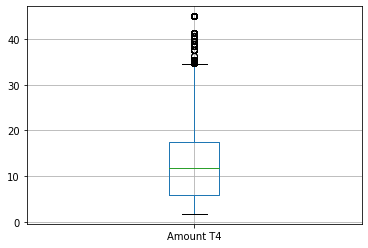

In [120]:
sales_trimester_4_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month > 9])
sales_trimester_4_df = sales_trimester_4_df[['CustomerID','Sale','Qta']]
sales_trimester_4_df['Amount'] = sales_trimester_4_df['Sale'] * sales_trimester_4_df['Qta']
sales_trimester_4_df = sales_trimester_4_df.drop(columns=['Sale'])
sales_trimester_4_df.columns = ['CustomerID','Qta T4','Amount T4']
sales_trimester_4_df.boxplot(column=['Amount T4'])
plt.savefig(img.format('amount_t4_boxplot'))

In [121]:
sales_trimester_4_df['Amount T4'].describe()

count    49326.000000
mean        12.502199
std          7.814476
min          1.700000
25%          5.900000
50%         11.800000
75%         17.400000
max         45.000000
Name: Amount T4, dtype: float64

In [122]:
sales_trimester_4_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49326 entries, 22523 to 516366
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  49326 non-null  Int64  
 1   Qta T4      49326 non-null  int64  
 2   Amount T4   49326 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 1.6 MB


In [123]:
sales_trimester_4_df = sales_trimester_4_df[sales_trimester_4_df['Amount T4'] <= sales_trimester_4_df['Amount T4'].describe()[6]]
sales_trimester_4_df = sales_trimester_4_df[sales_trimester_4_df['Amount T4'] >= sales_trimester_4_df['Amount T4'].describe()[4]]
sales_trimester_4_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28746 entries, 22523 to 516366
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  28746 non-null  Int64  
 1   Qta T4      28746 non-null  int64  
 2   Amount T4   28746 non-null  float64
dtypes: Int64(1), float64(1), int64(1)
memory usage: 926.4 KB


After the outliers removal in the Trimester 4 we have 28746 records (instead of 49326), keeping just the records where customers spent from 5.90 to 17.40.

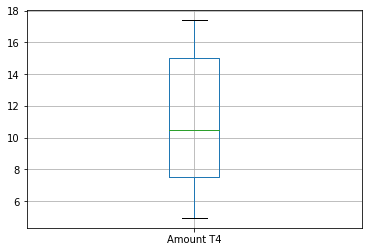

In [124]:
sales_trimester_4_df.boxplot(column=['Amount T4'])
plt.savefig(img.format('amount_t4_boxplot_without_outliers'))

In [125]:
sales_trimester_4_df = sales_trimester_4_df.groupby(['CustomerID'], as_index=False).mean()
sales_trimester_4_df.columns = ['CustomerID','Mean Qta T4','Mean Money Spent T4']
sales_trimester_4_df

,CustomerID,Mean Qta T4,Mean Money Spent T4
0,12347,10.000000,12.900000
1,12349,8.800000,14.474667
2,12358,8.000000,15.000000
3,12359,7.800000,14.682000
4,12360,8.545455,12.507273
...,...,...,...
2113,18276,8.000000,13.032000
2114,18277,8.000000,11.540000
2115,18281,8.000000,15.900000
2116,18283,3.551724,7.372414


In [126]:
sales_trimester_1_df = sales_trimester_1_df.set_index('CustomerID')
sales_trimester_2_df = sales_trimester_2_df.set_index('CustomerID')
sales_trimester_3_df = sales_trimester_3_df.set_index('CustomerID')
sales_trimester_4_df = sales_trimester_4_df.set_index('CustomerID')

sales_trimester_df = customers
sales_trimester_df = sales_trimester_df.join(sales_trimester_1_df, on='CustomerID')
sales_trimester_df = sales_trimester_df.join(sales_trimester_2_df, on='CustomerID')
sales_trimester_df = sales_trimester_df.join(sales_trimester_3_df, on='CustomerID')
sales_trimester_df = sales_trimester_df.join(sales_trimester_4_df, on='CustomerID')
sales_trimester_df = sales_trimester_df.fillna(0)

sales_trimester_df = sales_trimester_df.set_index('CustomerID')

In [127]:
# sales_trimester_df.to_csv(featureFolder.format('sales_trimester.csv'))
sales_trimester_df

,Mean Qta T1,Mean Money Spent T1,Mean Qta T2,Mean Money Spent T2,Mean Qta T3,Mean Money Spent T3,Mean Qta T4,Mean Money Spent T4
CustomerID,,,,,,,,
17850,6.119205,10.480927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13047,7.866667,14.900000,7.473684,13.774737,0.000000,0.000000,7.846154,13.416923
12583,12.000000,10.200000,8.588235,11.977647,9.153846,13.889231,9.733333,11.169333
14688,7.396226,11.218868,5.529412,8.652941,8.538462,10.636923,7.055556,10.025000
15311,5.066667,8.745667,3.778947,7.496632,4.898990,8.619293,5.567376,9.089787
...,...,...,...,...,...,...,...,...
14520,0.000000,0.000000,0.000000,0.000000,12.000000,10.200000,0.000000,0.000000
13436,0.000000,0.000000,0.000000,0.000000,6.400000,13.848000,0.000000,0.000000
15520,0.000000,0.000000,0.000000,0.000000,12.000000,12.600000,0.000000,0.000000


In [128]:
# dropping all zero values to compare customers behavior
sales_trimester_nonzero_df = sales_trimester_df[sales_trimester_df['Mean Money Spent T1'] != 0]
sales_trimester_nonzero_df = sales_trimester_df[sales_trimester_df['Mean Money Spent T2'] != 0]
sales_trimester_nonzero_df = sales_trimester_df[sales_trimester_df['Mean Money Spent T3'] != 0]
sales_trimester_nonzero_df = sales_trimester_df[sales_trimester_df['Mean Money Spent T4'] != 0]

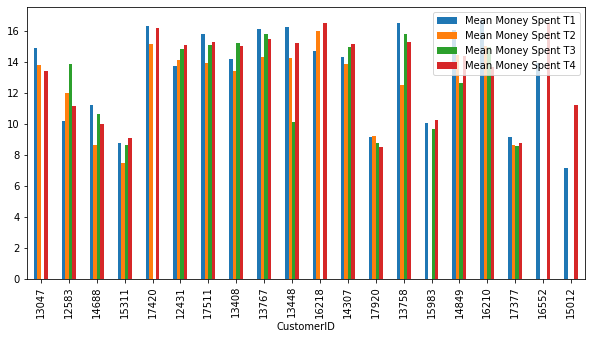

In [129]:
sales_trimester_nonzero_df[['Mean Money Spent T1','Mean Money Spent T2','Mean Money Spent T3', 'Mean Money Spent T4']][:20].plot(kind='bar',figsize=(10,5))
plt.savefig(img.format('customers_with_T1234_bar'))

Here we can see the comparison between just 20 customers (for the sake of presentation) representing the total expense in the 4 different trimesters. Some of the customers seems to spend mostly in one of the trimesters, others are more constant buyers.

In [130]:
sales_trimester_df.corr(method='pearson')

,Mean Qta T1,Mean Money Spent T1,Mean Qta T2,Mean Money Spent T2,Mean Qta T3,Mean Money Spent T3,Mean Qta T4,Mean Money Spent T4
Mean Qta T1,1.000000,0.951877,0.155323,0.143008,0.103255,0.094289,0.079617,0.069012
Mean Money Spent T1,0.951877,1.000000,0.146771,0.146033,0.086805,0.088392,0.063862,0.061986
Mean Qta T2,0.155323,0.146771,1.000000,0.957645,0.168536,0.164302,0.123659,0.107923
Mean Money Spent T2,0.143008,0.146033,0.957645,1.000000,0.147055,0.156241,0.112355,0.105544
Mean Qta T3,0.103255,0.086805,0.168536,0.147055,1.000000,0.942601,0.109298,0.091955
Mean Money Spent T3,0.094289,0.088392,0.164302,0.156241,0.942601,1.000000,0.095947,0.093110
Mean Qta T4,0.079617,0.063862,0.123659,0.112355,0.109298,0.095947,1.000000,0.949854
Mean Money Spent T4,0.069012,0.061986,0.107923,0.105544,0.091955,0.093110,0.949854,1.000000


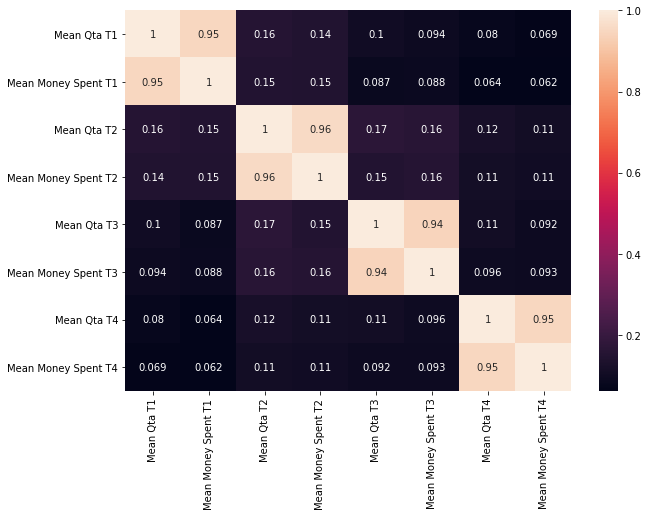

In [131]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(sales_trimester_df.corr(method='pearson'), annot=True, ax=ax)
plt.savefig(img.format('T1234_heatmap_correlation'))

We can see that the purchasing behavior of the customers among the the different trimesters are less correlated with respect to the semesters and quarters - still being quite highly correlated (~0.55). This highlights a pretty seasonal need of some of the products bought.

Let's now consider the best selling products in a variable time window: by semester, by quarter and by trimester.

## Sales of the 1st and 2nd semester per product

In [132]:
qta_semester_1_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month <= 6])
qta_semester_1_df = qta_semester_1_df[['ProdID','Qta']]
qta_semester_1_df.columns = ['ProdID','tot_qta_sem_1']
qta_semester_1_df = qta_semester_1_df.groupby(['ProdID'], as_index=False).sum()

qta_semester_2_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month > 6])
qta_semester_2_df = qta_semester_2_df[['ProdID','Qta']]
qta_semester_2_df.columns = ['ProdID','tot_qta_sem_2']
qta_semester_2_df = qta_semester_2_df.groupby(['ProdID'], as_index=False).sum()

qta_semester_df = qta_semester_1_df.join(qta_semester_2_df.set_index('ProdID'), on='ProdID').fillna(0)
qta_semester_df = qta_semester_df.set_index('ProdID')

In [133]:
qta_semester_df

,tot_qta_sem_1,tot_qta_sem_2
ProdID,,
10002,140,102.0
10080,2,0.0
10125,32,30.0
10133,104,54.0
10135,226,279.0
...,...,...
90214A,2,30.0
90214J,2,8.0
90214K,2,15.0


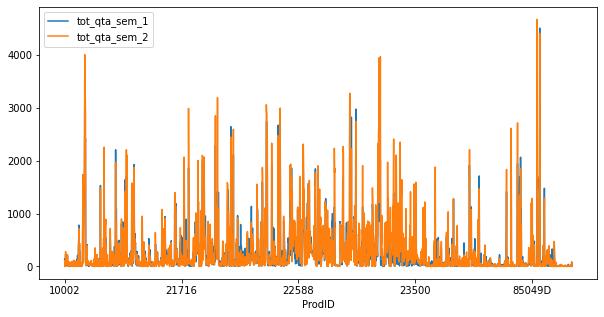

In [134]:
qta_semester_df.plot(figsize=(10,5))
plt.savefig(img.format('ProdID_qta_sem12'))

In [135]:
corr_sem = qta_semester_df['tot_qta_sem_1'].corr(qta_semester_df['tot_qta_sem_2'], method='pearson')
print('Semesters correlation: %f' % corr_sem)

Semesters correlation: 0.909888


We can observe that the correlation is very high, so the quantities sold in the two semesters are pretty much the same.

## Sales of 1st, 2nd and 3rd quarter per product

In [136]:
qta_quarter_1_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month <= 4])
qta_quarter_1_df = qta_quarter_1_df[['ProdID','Qta']]
qta_quarter_1_df.columns = ['ProdID','tot_qta_quarter_1']
qta_quarter_1_df = qta_quarter_1_df.groupby(['ProdID'], as_index=False).sum()

qta_quarter_2_df = deepcopy(grouped_df[((grouped_df['BasketDate'].dt.month > 4) & (grouped_df['BasketDate'].dt.month <= 8))])
qta_quarter_2_df = qta_quarter_2_df[['ProdID','Qta']]
qta_quarter_2_df.columns = ['ProdID','tot_qta_quarter_2']
qta_quarter_2_df = qta_quarter_2_df.groupby(['ProdID'], as_index=False).sum()

qta_quarter_3_df = deepcopy(grouped_df[((grouped_df['BasketDate'].dt.month > 8) & (grouped_df['BasketDate'].dt.month <= 12))])
qta_quarter_3_df = qta_quarter_3_df[['ProdID','Qta']]
qta_quarter_3_df.columns = ['ProdID','tot_qta_quarter_3']
qta_quarter_3_df = qta_quarter_3_df.groupby(['ProdID'], as_index=False).sum()

qta_quarter_df = qta_quarter_1_df.join(qta_quarter_2_df.set_index('ProdID'), on='ProdID').fillna(0)
qta_quarter_df = qta_quarter_df.join(qta_quarter_3_df.set_index('ProdID'), on='ProdID').fillna(0)
qta_quarter_df = qta_quarter_df.set_index('ProdID')

In [137]:
qta_quarter_df

,tot_qta_quarter_1,tot_qta_quarter_2,tot_qta_quarter_3
ProdID,,,
10002,128,24.0,90.0
10080,2,0.0,0.0
10125,29,16.0,17.0
10133,87,17.0,54.0
10135,184,102.0,219.0
...,...,...,...
90214A,2,12.0,18.0
90214J,2,0.0,8.0
90214K,2,6.0,9.0


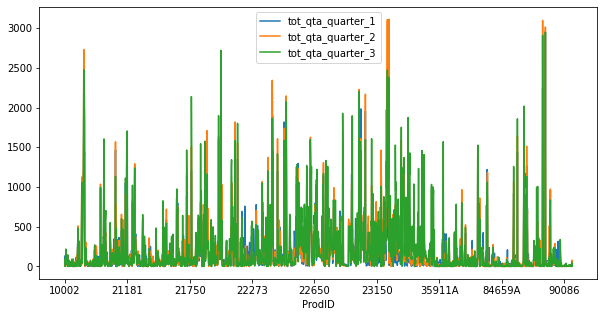

In [138]:
qta_quarter_df.plot(figsize=(10,5))
plt.savefig(img.format('ProdID_q123'))

In [139]:
qta_quarter_df.corr(method='pearson')

,tot_qta_quarter_1,tot_qta_quarter_2,tot_qta_quarter_3
tot_qta_quarter_1,1.000000,0.876951,0.809526
tot_qta_quarter_2,0.876951,1.000000,0.880205
tot_qta_quarter_3,0.809526,0.880205,1.000000


High correlation between each quarter, so products are bought pretty much uniformly.

## Sales of 1st, 2nd, 3rd and 4th trimester per product

In [140]:
qta_trim_1_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month <= 3])
qta_trim_1_df = qta_trim_1_df[['ProdID','Qta']]
qta_trim_1_df.columns = ['ProdID','tot_qta_trim_1']
qta_trim_1_df = qta_trim_1_df.groupby(['ProdID'], as_index=False).sum()

qta_trim_2_df = deepcopy(grouped_df[((grouped_df['BasketDate'].dt.month > 3) & (grouped_df['BasketDate'].dt.month <= 6))])
qta_trim_2_df = qta_trim_2_df[['ProdID','Qta']]
qta_trim_2_df.columns = ['ProdID','tot_qta_trim_2']
qta_trim_2_df = qta_trim_2_df.groupby(['ProdID'], as_index=False).sum()

qta_trim_3_df = deepcopy(grouped_df[((grouped_df['BasketDate'].dt.month > 6) & (grouped_df['BasketDate'].dt.month <= 9))])
qta_trim_3_df = qta_trim_3_df[['ProdID','Qta']]
qta_trim_3_df.columns = ['ProdID','tot_qta_trim_3']
qta_trim_3_df = qta_trim_3_df.groupby(['ProdID'], as_index=False).sum()

qta_trim_4_df = deepcopy(grouped_df[grouped_df['BasketDate'].dt.month > 9])
qta_trim_4_df = qta_trim_4_df[['ProdID','Qta']]
qta_trim_4_df.columns = ['ProdID','tot_qta_trim_4']
qta_trim_4_df = qta_trim_4_df.groupby(['ProdID'], as_index=False).sum()

qta_trim_df = qta_trim_1_df.join(qta_trim_2_df.set_index('ProdID'), on='ProdID').fillna(0)
qta_trim_df = qta_trim_df.join(qta_trim_3_df.set_index('ProdID'), on='ProdID').fillna(0)
qta_trim_df = qta_trim_df.join(qta_trim_4_df.set_index('ProdID'), on='ProdID').fillna(0)
qta_trim_df = qta_trim_df.set_index('ProdID')

In [141]:
qta_trim_df

,tot_qta_trim_1,tot_qta_trim_2,tot_qta_trim_3,tot_qta_trim_4
ProdID,,,,
10002,126,14.0,54.0,48.0
10080,2,0.0,0.0,0.0
10125,19,13.0,25.0,5.0
10133,72,32.0,22.0,32.0
10135,181,45.0,127.0,152.0
...,...,...,...,...
90210C,2,0.0,20.0,12.0
90214J,2,0.0,2.0,6.0
90214K,2,0.0,9.0,6.0


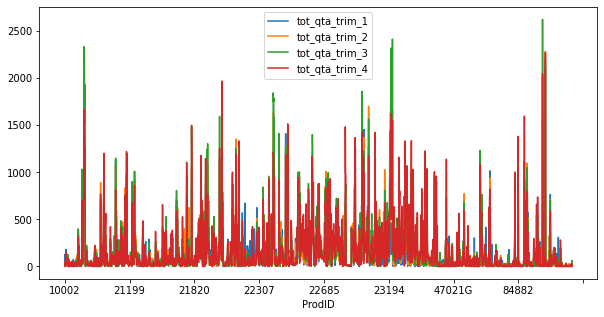

In [142]:
qta_trim_df.plot(figsize=(10,5))
plt.savefig(img.format('ProdID_qta_trim1234'))

1. Min-Max scaling for new entries?
2. How rescale amount of each quarters? With min and max of each quarters?

## Entropy of money spent (*E*)

In [143]:
grouped_df_moneyspent = deepcopy(customers)
grouped_df_moneyspent.set_index('CustomerID')
temp = deepcopy(grouped_df)
temp['Money Spent'] = (temp['Sale']*temp['Qta']).round()
temp = temp.set_index('CustomerID')

grouped_df_moneyspent = grouped_df_moneyspent.join(temp, on='CustomerID')
grouped_df_moneyspent.sort_values('CustomerID', inplace=True)
grouped_df_moneyspent = grouped_df_moneyspent[['CustomerID', 'BasketID', 'Money Spent']] 
grouped_df_moneyspent


g_sum = grouped_df_moneyspent.groupby('CustomerID')['Money Spent'].transform('sum')
values = grouped_df_moneyspent['Money Spent']/g_sum
grouped_df_moneyspent['Money Spent Entropy'] = -(values*np.log(values))

entropy_df = grouped_df_moneyspent.groupby('CustomerID',as_index=False,sort=False)['Money Spent Entropy'].sum()

entropy_df = entropy_df.set_index('CustomerID')
entropy_df.to_csv(featureFolder.format('money_spent_entropy.csv'))
entropy_df

,Money Spent Entropy
CustomerID,
12347,4.518601
12349,3.535598
12350,2.664537
12352,3.622310
12353,0.673012
...,...
18280,1.775971
18281,0.692627
18282,1.366748


# Merge all the feature in a single dataset

In [144]:
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir(featureFF) if isfile(join(featureFF, f))]
dfs = []
for dataset in onlyfiles:
    dfs.append(pd.read_csv(featureFF+dataset))

dataset = dfs.pop(0).set_index('CustomerID')

for df_temp in dfs:
    df_temp = df_temp.set_index('CustomerID')
    dataset = dataset.join(df_temp, on='CustomerID')
dataset.describe()
dataset

,Mean Days btw Purchases,Min Days btw Purchases,Max Days btw Purchases,Max Products In Basket,Min Products In Basket,Mean Products In Basket,Money Spent Entropy,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3,Distinct Products,Distinct Baskets,Total Products
CustomerID,,,,,,,,,,,,,,,,
12347,167.833330,64,265,26,4,14.142857,4.518601,7.294118,13.050588,9.000000,14.376154,8.923077,13.043077,66,7,916
12349,697.000000,697,697,35,35,35.000000,3.535598,0.000000,0.000000,0.000000,0.000000,8.800000,14.474667,35,1,328
12350,697.000000,697,697,15,15,15.000000,2.664537,11.714286,13.728571,0.000000,0.000000,0.000000,0.000000,15,1,172
12352,85.500000,5,201,8,1,5.428571,3.622310,10.416667,14.894167,0.000000,0.000000,8.250000,15.512500,31,7,365
12353,697.000000,697,697,2,2,2.000000,0.673012,0.000000,0.000000,7.000000,14.650000,0.000000,0.000000,2,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,697.000000,697,697,6,6,6.000000,1.775971,0.000000,0.000000,5.200000,16.140000,0.000000,0.000000,6,1,34
18281,697.000000,697,697,2,2,2.000000,0.692627,0.000000,0.000000,0.000000,0.000000,8.000000,15.900000,2,1,16
18282,85.000000,85,85,2,2,2.000000,1.366748,4.000000,13.000000,6.000000,17.700000,0.000000,0.000000,4,2,25


# Removing noise

In [145]:
dataset

,Mean Days btw Purchases,Min Days btw Purchases,Max Days btw Purchases,Max Products In Basket,Min Products In Basket,Mean Products In Basket,Money Spent Entropy,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3,Distinct Products,Distinct Baskets,Total Products
CustomerID,,,,,,,,,,,,,,,,
12347,167.833330,64,265,26,4,14.142857,4.518601,7.294118,13.050588,9.000000,14.376154,8.923077,13.043077,66,7,916
12349,697.000000,697,697,35,35,35.000000,3.535598,0.000000,0.000000,0.000000,0.000000,8.800000,14.474667,35,1,328
12350,697.000000,697,697,15,15,15.000000,2.664537,11.714286,13.728571,0.000000,0.000000,0.000000,0.000000,15,1,172
12352,85.500000,5,201,8,1,5.428571,3.622310,10.416667,14.894167,0.000000,0.000000,8.250000,15.512500,31,7,365
12353,697.000000,697,697,2,2,2.000000,0.673012,0.000000,0.000000,7.000000,14.650000,0.000000,0.000000,2,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,697.000000,697,697,6,6,6.000000,1.775971,0.000000,0.000000,5.200000,16.140000,0.000000,0.000000,6,1,34
18281,697.000000,697,697,2,2,2.000000,0.692627,0.000000,0.000000,0.000000,0.000000,8.000000,15.900000,2,1,16
18282,85.000000,85,85,2,2,2.000000,1.366748,4.000000,13.000000,6.000000,17.700000,0.000000,0.000000,4,2,25


In [146]:
#selected_features = ['Min Days btw Purchases','Min Products In Basket','Money Spent Entropy','Mean Qta Q1','Mean Money Spent Q2','Mean Money Spent Q3','Distinct Products','Distinct Baskets','Total Products']
dataset_wo_noise = deepcopy(dataset)
features = [f for f in list(dataset_wo_noise.columns) if f not in ['Mean Qta Q1', 'Mean Money Spent Q1', 'Mean Qta Q2', 'Mean Money Spent Q2', 'Mean Qta Q3', 'Mean Money Spent Q3', 'Min Days btw Purchases', 'Max Days btw Purchases', 'Max Products In Basket', 'Min Products In Basket']]
for feature in features:
    dataset_wo_noise[feature] = dataset_wo_noise[dataset_wo_noise[feature] <= dataset_wo_noise[feature].describe()[6]]
    dataset_wo_noise[feature] = dataset_wo_noise[dataset_wo_noise[feature] >= dataset_wo_noise[feature].describe()[4]]
dataset_wo_noise = dataset_wo_noise.dropna()

In [147]:
dataset_wo_noise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 12353 to 18287
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Mean Days btw Purchases  1468 non-null   float64
 1   Min Days btw Purchases   1468 non-null   int64  
 2   Max Days btw Purchases   1468 non-null   int64  
 3   Max Products In Basket   1468 non-null   int64  
 4   Min Products In Basket   1468 non-null   int64  
 5   Mean Products In Basket  1468 non-null   float64
 6   Money Spent Entropy      1468 non-null   float64
 7   Mean Qta Q1              1468 non-null   float64
 8   Mean Money Spent Q1      1468 non-null   float64
 9   Mean Qta Q2              1468 non-null   float64
 10  Mean Money Spent Q2      1468 non-null   float64
 11  Mean Qta Q3              1468 non-null   float64
 12  Mean Money Spent Q3      1468 non-null   float64
 13  Distinct Products        1468 non-null   float64
 14  Distinct Baskets   

In [148]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4035 entries, 12347 to 18287
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Mean Days btw Purchases  4035 non-null   float64
 1   Min Days btw Purchases   4035 non-null   int64  
 2   Max Days btw Purchases   4035 non-null   int64  
 3   Max Products In Basket   4035 non-null   int64  
 4   Min Products In Basket   4035 non-null   int64  
 5   Mean Products In Basket  4035 non-null   float64
 6   Money Spent Entropy      4035 non-null   float64
 7   Mean Qta Q1              4035 non-null   float64
 8   Mean Money Spent Q1      4035 non-null   float64
 9   Mean Qta Q2              4035 non-null   float64
 10  Mean Money Spent Q2      4035 non-null   float64
 11  Mean Qta Q3              4035 non-null   float64
 12  Mean Money Spent Q3      4035 non-null   float64
 13  Distinct Products        4035 non-null   int64  
 14  Distinct Baskets   

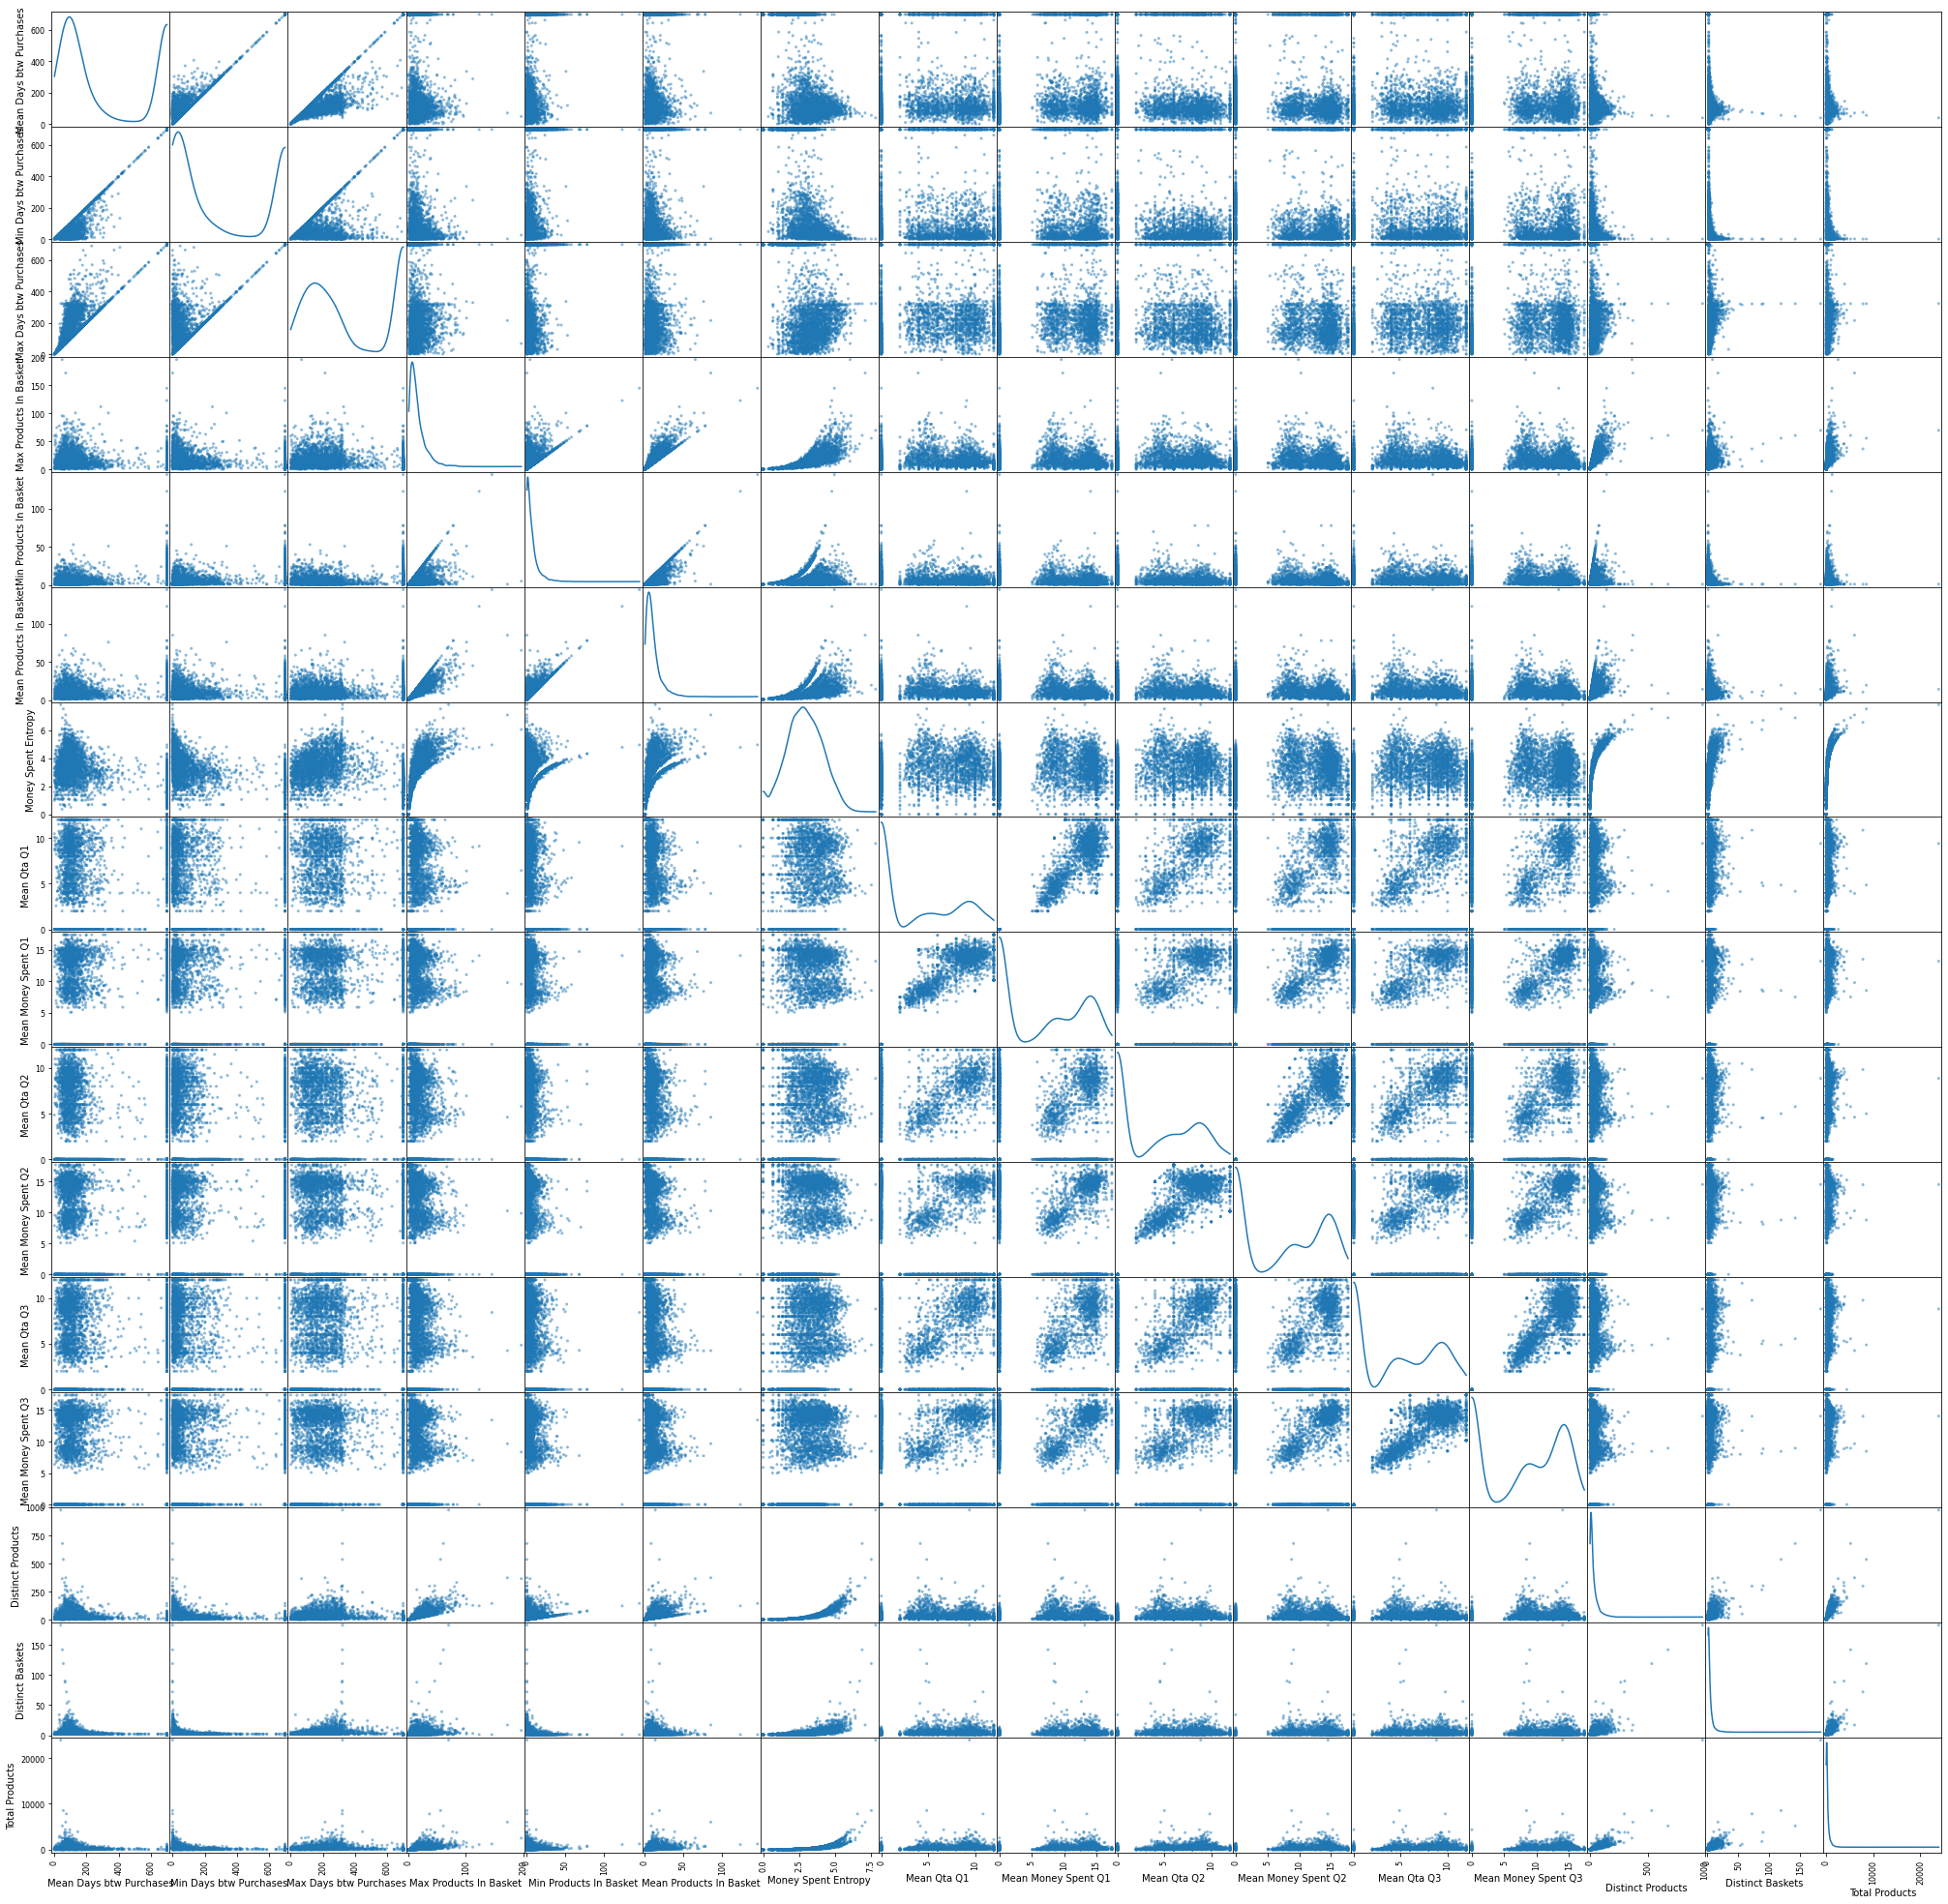

In [149]:
pd.plotting.scatter_matrix(dataset, diagonal='kde', figsize=(35,35))
plt.savefig(img.format('scatter_matrix_behavior'))

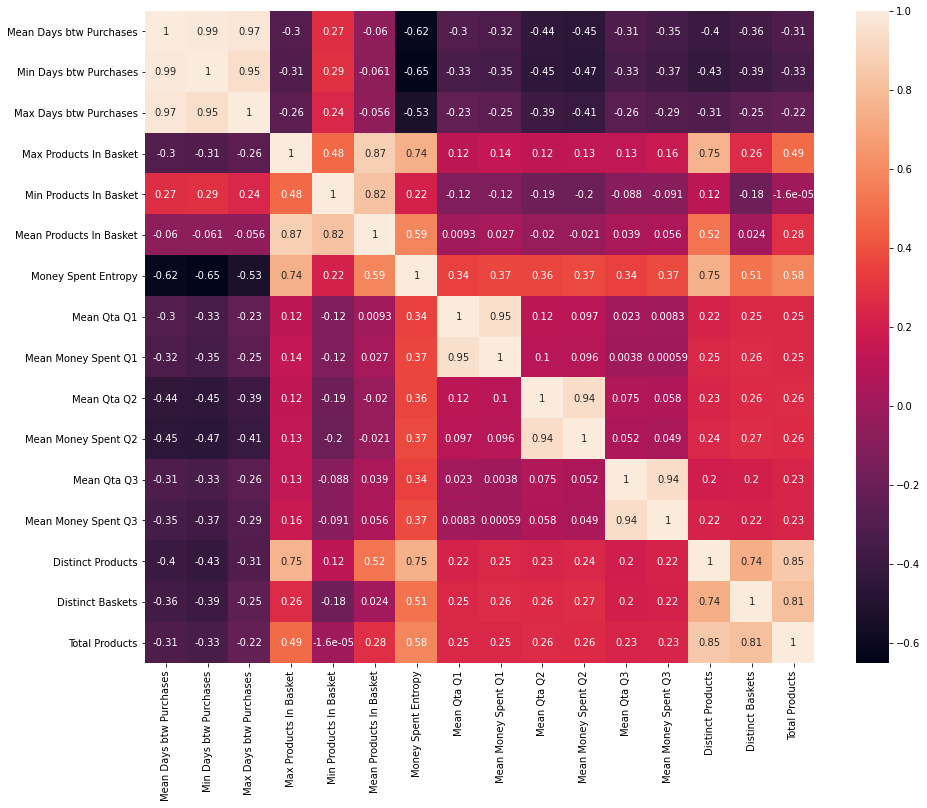

In [150]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(dataset.corr(method='pearson'), annot=True, ax=ax)
plt.savefig(img.format('correlation_matrix_behavior'))

In [151]:
dataset.to_csv(dataFolder.format('customer_behavior.csv'))
customers = dataset.index
customers

Int64Index([12347, 12349, 12350, 12352, 12353, 12354, 12355, 12356, 12357,
            12358,
            ...
            18272, 18274, 18276, 18277, 18278, 18280, 18281, 18282, 18283,
            18287],
           dtype='int64', name='CustomerID', length=4035)

In [152]:
ddd = deepcopy(dataset)

np.set_printoptions(precision=2)
print(ddd.columns)
for i, col in enumerate(ddd.columns):
    ddd[i] = ddd[col]
    del ddd[col]
print(ddd.describe().to_latex())

Index(['Mean Days btw Purchases', 'Min Days btw Purchases',
       'Max Days btw Purchases', 'Max Products In Basket',
       'Min Products In Basket', 'Mean Products In Basket',
       'Money Spent Entropy', 'Mean Qta Q1', 'Mean Money Spent Q1',
       'Mean Qta Q2', 'Mean Money Spent Q2', 'Mean Qta Q3',
       'Mean Money Spent Q3', 'Distinct Products', 'Distinct Baskets',
       'Total Products'],
      dtype='object')
\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
{} &           0  &           1  &           2  &           3  &           4  &           5  &           6  &           7  &           8  &           9  &           10 &           11 &           12 &           13 &           14 &            15 \\
\midrule
count &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &  4035.000000 &   4035.000000 \\
mean  &   340.061559 &  

## Normalization

In [153]:
x_scaled = StandardScaler().fit_transform(dataset)
dataset = pd.DataFrame(x_scaled, columns=dataset.columns, index=customers)
dataset.to_csv(dataFolder.format('customer_behavior_normalized.csv'))
dataset

,Mean Days btw Purchases,Min Days btw Purchases,Max Days btw Purchases,Max Products In Basket,Min Products In Basket,Mean Products In Basket,Money Spent Entropy,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3,Distinct Products,Distinct Baskets,Total Products
CustomerID,,,,,,,,,,,,,,,,
12347,-0.596612,-0.796004,-0.436156,0.723799,-0.379511,0.346875,1.316072,0.774357,1.081963,1.177911,1.098092,0.957169,0.846350,0.865201,0.516417,1.048523
12349,1.236463,1.235554,1.196762,1.349195,3.376708,2.542669,0.542997,-0.901621,-0.951903,-0.992026,-1.038769,0.928488,1.071320,0.111323,-0.439867,0.054326
12350,1.236463,1.235554,1.196762,-0.040574,0.953341,0.437113,-0.142042,1.789984,1.187623,-0.992026,-1.038769,-1.122254,-1.203325,-0.375050,-0.439867,-0.209440
12352,-0.881821,-0.985360,-0.678070,-0.526993,-0.743016,-0.570546,0.611191,1.491829,1.369275,-0.992026,-1.038769,0.800316,1.234412,0.014049,0.516417,0.116886
12353,1.236463,1.235554,1.196762,-0.943923,-0.621847,-0.931499,-1.708262,-0.901621,-0.951903,0.695702,1.138796,-1.122254,-1.203325,-0.691192,-0.439867,-0.476588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,1.236463,1.235554,1.196762,-0.665970,-0.137174,-0.510387,-0.840848,-0.901621,-0.951903,0.261715,1.360269,-1.122254,-1.203325,-0.593917,-0.439867,-0.442772
18281,1.236463,1.235554,1.196762,-0.943923,-0.621847,-0.931499,-1.692836,-0.901621,-0.951903,-0.992026,-1.038769,0.742057,1.295306,-0.691192,-0.439867,-0.473207
18282,-0.883553,-0.728607,-1.116538,-0.943923,-0.621847,-0.931499,-1.162678,0.017464,1.074079,0.454598,1.592146,-1.122254,-1.203325,-0.642555,-0.280486,-0.457989
